# Libraries and functions

In [ ]:
pip install visualkeras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from skimage import metrics
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import cv2
from keras.layers import Input, Conv2D, Add, BatchNormalization, Activation, ReLU
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import ResNet50
import visualkeras
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# This function calculates the Peak Signal-to-Noise Ratio (PSNR) between two images where
# y_true and y_pred are the true and predicted images, respectively, 
# The higher the PSNR, the more similar the two images are.
def PSNR(y_true, y_pred):
    max_pixel = 255
    return 20 * np.log10(max_pixel / np.sqrt(np.mean((y_true - y_pred)**2)))

# This function calculates the PSNR using TensorFlow's built-in psnr() function.
# y_true and y_pred are the true and predicted images, respectively, and max_pixel is the maximum pixel value.
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 255)

# This function calculates the Structural Similarity Index (SSIM) between two images x and y.
# sigma is the standard deviation of the Gaussian filter used in the calculation.
# The SSIM ranges from -1 to 1, with 1 indicating perfect similarity.
def SSIM(x, y):
    return metrics.structural_similarity(x, y, sigma=1.5,use_sample_covariance= False, gaussian_weights=True, multichannel=True, data_range=255)

# This function calculates the SSIM using TensorFlow's built-in ssim() function.
# y_true and y_pred are the true and predicted images, respectively, and max_pixel is the maximum pixel value.
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 255)

# This function calculates the L1 loss between two images y_true and y_pred.
# The L1 loss is the mean absolute difference between the pixel values of the two images.
def L1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# This function calculates the pixel loss between two images.
# The pixel loss is usually defined as the mean squared difference between the pixel values of the two images.
def pixel_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

# The PSNR loss is the inverse of the mean PSNR between the two images
def PSNR_loss(y_true, y_pred):
    return  1/tf.reduce_mean(psnr(y_true, y_pred))

# The SSIM loss is 1 minus the mean SSIM between the two images
def SSIM_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255))

# This function calculates the combined PSNR and SSIM loss between two images
# The PSNR-SSIM loss is the sum of the SSIM loss and half of the PSNR loss
def PSNR_SSIM_loss(y_true, y_pred):
    return SSIM_loss(y_true, y_pred) +  0.5 * PSNR_loss(y_true, y_pred)

In [ ]:
# This function is used to normalize the pixel values of the input image before passing it to the networks
def min_max_scaling(inputs):
    min_val = tf.reduce_min(inputs)
    max_val = tf.reduce_max(inputs)
    inputs = (inputs - min_val) / (max_val - min_val)
    return inputs, min_val, max_val

In [ ]:
# Plot the results
# create a figure with 2 rows and 5 columns
def plot_images(GT_train, GT_test, blurred_train, blurred_test, pixelated_train, pixelated_test, train_pred_blurred, test_pred_blurred, train_pred_pixelated, test_pred_pixelated):
  fig, axes = plt.subplots(2, 5, figsize=(16, 6))
  
  # set the titles for each subplot
  axes[0, 0].set_title("Original Image", fontsize=14)
  axes[0, 1].set_title("Blurred Image", fontsize=14)
  axes[0, 2].set_title("Reconstructed Blurred", fontsize=14)
  axes[0, 3].set_title("Pixelated Image", fontsize=14)
  axes[0, 4].set_title("Reconstructed Pixelated", fontsize=14)

  # plot the images
  axes[0, 0].imshow(GT_train[7]/255)
  axes[0, 0].axis('off')
  axes[0, 0].text(0.25, -0.1, "PSNR/SSIM", fontsize=14, transform=axes[0,0].transAxes)  
  axes[0, 0].text(-0.15, 0.25, "Training set", rotation=90, fontsize=14, transform=axes[0,0].transAxes)

  axes[0, 1].imshow(blurred_train[7]/255)
  axes[0, 1].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_train[0],blurred_train[0]),2)), str(round(SSIM(GT_train[0],blurred_train[0]),2)) 
  axes[0, 1].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[0,1].transAxes)  

  axes[0, 2].imshow(train_pred_blurred[7]/255)
  axes[0, 2].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_train[0],train_pred_blurred[0]),2)), str(round(SSIM(GT_train[0],train_pred_blurred[0]),2)) 
  axes[0, 2].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[0,2].transAxes)  

  axes[0, 3].imshow(pixelated_train[7]/255)
  axes[0, 3].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_train[0],pixelated_train[0]),2)), str(round(SSIM(GT_train[0],pixelated_train[0]),2)) 
  axes[0, 3].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[0,3].transAxes)  

  axes[0, 4].imshow(train_pred_pixelated[7]/255)
  axes[0, 4].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_train[0],train_pred_pixelated[0]),2)), str(round(SSIM(GT_train[0],train_pred_pixelated[0]),2)) 
  axes[0, 4].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[0,4].transAxes)  

  axes[1, 0].imshow(GT_test[9]/255)
  axes[1, 0].axis('off')
  axes[1, 0].text(0.25, -0.1, "PSNR/SSIM", fontsize=14, transform=axes[1,0].transAxes)  
  axes[1, 0].text(-0.15, 0.3, "Test set", rotation=90, fontsize=14, transform=axes[1,0].transAxes)

  axes[1, 1].imshow(blurred_test[9]/255)
  axes[1, 1].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_test[0],blurred_test[0]),2)), str(round(SSIM(GT_test[0],blurred_test[0]),2)) 
  axes[1, 1].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[1,1].transAxes)  

  axes[1, 2].imshow(test_pred_blurred[9]/255)
  axes[1, 2].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_test[0],test_pred_blurred[0]),2)), str(round(SSIM(GT_test[0],test_pred_blurred[0]),2)) 
  axes[1, 2].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14,  transform=axes[1,2].transAxes)  

  axes[1, 3].imshow(pixelated_test[9]/255)
  axes[1, 3].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_test[0],pixelated_test[0]),2)), str(round(SSIM(GT_test[0],pixelated_test[0]),2)) 
  axes[1, 3].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[1,3].transAxes)  

  axes[1, 4].imshow(test_pred_pixelated[9]/255)
  axes[1, 4].axis('off')
  psnr_value, ssim_value = str(round(PSNR(GT_test[0],test_pred_pixelated[0]),2)), str(round(SSIM(GT_test[0],test_pred_pixelated[0]),2)) 
  axes[1, 4].text(0.25, -0.1, psnr_value +'/' + ssim_value, fontsize=14, transform=axes[1,4].transAxes) 
  
  plt.show()


In [ ]:
# Plots the training and validation loss as a function of the epoch.
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='train_loss', linewidth=3)
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss', linewidth=3)
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')
  plt.legend()

# Plots the training and validation PSNR as a function of the epoch.  
def plot_psnr(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['psnr'],label='train_psnr', linewidth=3)
  plt.plot(history.epoch,history.history['val_psnr'],label='val_psnr', linewidth=3)
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('PSNR')
  plt.legend()

# Plots the training and validation SSIM as a function of the epoch. 
def plot_ssim(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['ssim'],label='train_ssim', linewidth=3)
  plt.plot(history.epoch,history.history['val_ssim'],label='val_ssim', linewidth=3)
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('SSIM')
  plt.legend()

#  Plots the training and validation PSNR for several loss functions (L2, L1, PSNR, SSIM, and PSNR+SSIM) as a function of the epoch.
def plot_all_psnr(history1,history2,history3,history4,history5):
  plt.figure(figsize=(10,6))
  plt.plot(history1.epoch,history1.history['psnr'],label='L2', linewidth=3)
  plt.plot(history1.epoch,history1.history['val_psnr'],'--',label='L2_val', linewidth=3)
  plt.plot(history2.epoch,history2.history['psnr'],label='L1', linewidth=3)
  plt.plot(history2.epoch,history2.history['val_psnr'],'--',label='L1_val', linewidth=3)
  plt.plot(history3.epoch,history3.history['psnr'],label='PSNR', linewidth=3)
  plt.plot(history3.epoch,history3.history['val_psnr'],'--',label='PSNR_val', linewidth=3)
  plt.plot(history4.epoch,history4.history['psnr'],label='SSIM', linewidth=3)
  plt.plot(history4.epoch,history4.history['val_psnr'],'--',label='SSIM_val', linewidth=3)
  plt.plot(history5.epoch,history5.history['psnr'],label='PSNR+SSIM', linewidth=3)
  plt.plot(history5.epoch,history5.history['val_psnr'],'--',label='PSNR+SSIM_val', linewidth=3)
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('PSNR')
  plt.legend()

#  Plots the training and validation SSIM for several loss functions (L2, L1, PSNR, SSIM, and PSNR+SSIM) as a function of the epoch.
def plot_all_ssim(history1,history2,history3,history4,history5):
  plt.figure(figsize=(10,6))
  plt.plot(history1.epoch,history1.history['ssim'],label='L2', linewidth=3)
  plt.plot(history1.epoch,history1.history['val_ssim'],'--',label='L2_val', linewidth=3)
  plt.plot(history2.epoch,history2.history['ssim'],label='L1', linewidth=3)
  plt.plot(history2.epoch,history2.history['val_ssim'],'--',label='L1_val', linewidth=3)
  plt.plot(history3.epoch,history3.history['ssim'],label='PSNR', linewidth=3)
  plt.plot(history3.epoch,history3.history['val_ssim'],'--',label='PSNR_val', linewidth=3)
  plt.plot(history4.epoch,history4.history['ssim'],label='SSIM', linewidth=3)
  plt.plot(history4.epoch,history4.history['val_ssim'],'--',label='SSIM_val', linewidth=3)
  plt.plot(history5.epoch,history5.history['ssim'],label='PSNR+SSIM', linewidth=3)
  plt.plot(history5.epoch,history5.history['val_ssim'],'--',label='PSNR+SSIM_val', linewidth=3)
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('SSIM')
  plt.legend() 

# Introduction

In [ ]:
# Load the dataset
# The LFW dataset is a collection of facial images of famous people collected from the internet. 
images = fetch_lfw_people(resize=1.2, color=True, funneled=False).images[:2500] 
print("images shape", images.shape)

images shape (2500, 150, 112, 3)


In [ ]:
# Define the target size
target_size = (112, 112)

# Create a new list to store the resized images
tmp = []

# Loop through each image in the training set
for img in images:
    # Resize the image using OpenCV
    img_resized = cv2.resize(img, target_size)
    # Add the resized image to the new list
    tmp.append(img_resized)

# Convert the list of resized images to a numpy array
images = np.array(tmp)

In [ ]:
# Creating the pixelated version of the images
tmp = []
scale = 6
for img in images:
    # Downscale the image
    img_downscaled = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_NEAREST)
    # Upscale the downscaled image back to the original size
    img_pixelated = cv2.resize(img_downscaled, (img.shape[1], img.shape[0]),interpolation=cv2.INTER_NEAREST)
    tmp.append(img_pixelated)
images_pixelated = np.array(tmp)

# Creating the blurred version of the images
tmp = []
kernel_size = (15,15)
for img in images:
    tmp.append(cv2.GaussianBlur(img, kernel_size, 4))
images_blurred = np.array(tmp)

In [ ]:
# Split in training ad test data
X_train_pixelated, X_test_pixelated, y_train, y_test = train_test_split(images_pixelated,images, test_size=0.20, random_state=42)
X_train_blurred, X_test_blurred = train_test_split(images_blurred, test_size=0.20, random_state=42)


In [ ]:
# Save some RAM
images = None 
images_pixelated = None
images_blurred = None
tmp = None

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(X_train_pixelated.shape)
print(X_test_pixelated.shape)
print(X_train_blurred.shape)
print(X_test_blurred.shape)

(2000, 112, 112, 3)
(500, 112, 112, 3)
(2000, 112, 112, 3)
(500, 112, 112, 3)
(2000, 112, 112, 3)
(500, 112, 112, 3)


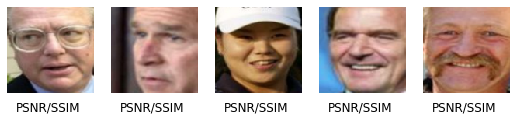

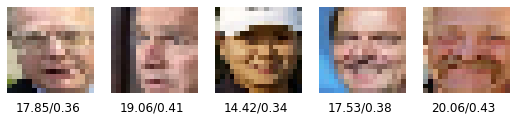

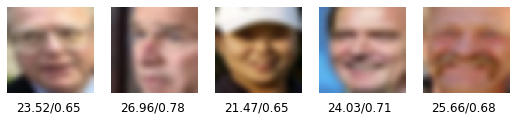

In [ ]:
n_rows = 1
n_cols = 5
plt.figure(figsize=(n_cols * 1.8, n_rows * 2))

for col in range(n_cols):
    index = col
    p = plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(y_train[index] / 255, cmap="binary", interpolation="nearest")
    plt.text(0.1, -0.2, "PSNR/SSIM", fontsize=12, transform=p.transAxes)  
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_cols * 1.8, n_rows * 2))

for col in range(n_cols):
    index = col
    p = plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train_pixelated[index] / 255, cmap="binary", interpolation="nearest")
    psnr_value, ssim_value = str(round(PSNR(y_train[index],X_train_pixelated[index]),2)), str(round(SSIM(y_train[index],X_train_pixelated[index]),2)) 
    plt.text(0.1, -0.2,  psnr_value +'/' + ssim_value, fontsize=12, transform=p.transAxes)  
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_cols * 1.8, n_rows * 2))

for col in range(n_cols):
    index = col
    p = plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train_blurred[index] / 255, cmap="binary", interpolation="nearest")        
    psnr_value, ssim_value = str(round(PSNR(y_train[index],X_train_blurred[index]),2)), str(round(SSIM(y_train[index],X_train_blurred[index]),2)) 
    plt.text(0.1, -0.2,  psnr_value +'/' + ssim_value, fontsize=12, transform=p.transAxes)   
    plt.axis("off")

plt.show()

# Models

In [ ]:
optimizer = Adam(learning_rate=0.0001)
callbacks = [keras.callbacks.EarlyStopping(patience=5)]

In [ ]:
# Simple Convolutional Neural Network
def build_model1():

  # Define the input shape for the image
  inputs = layers.Input(shape=(112, 112, 3))

  x, min_val, max_val = min_max_scaling(inputs)

  # Define the model

  x = layers.Conv2D(128, (9, 9), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(128, (4, 4), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(128, (4, 4), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(128, (4, 4), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)
  
  # Add the final output layer with sigmoid activation function
  x = layers.Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

  # Output in original scale
  x = x * (max_val - min_val) + min_val  
 
  model = tf.keras.Model(inputs, x)
  return model


In [ ]:
# SRResNet repurposed for image reconstruction

# Residual blocks
def residual_block_gen():
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,3,strides=1,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(64,3,strides=1,padding='same'),
    tf.keras.layers.BatchNormalization(),
  ])
  return model

def build_model2():
  inputs =tf.keras.layers.Input(shape=(112,112,3))

  x, min_val, max_val = min_max_scaling(inputs)

  input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(x)
  input_conv=tf.keras.layers.PReLU()(input_conv)

  Res=input_conv
  for _ in range(5):
    res_output=residual_block_gen()(Res)
    Res=tf.keras.layers.Add()([Res,res_output])

  Res=tf.keras.layers.Conv2D(64,9,padding='same')(Res)
  Res=tf.keras.layers.BatchNormalization()(Res)

  Res=tf.keras.layers.Add()([Res,input_conv])

  output=tf.keras.layers.Conv2D(3,9,activation='sigmoid',padding='same')(Res)

  # Output in original scale
  output = output * (max_val - min_val) + min_val  

  Resnet=tf.keras.models.Model(inputs,output)
  return Resnet

In [ ]:
# Residual Autoencoder architechture

# Residual blocks
def residual_block(input_tensor, filters, strides=1):
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([input_tensor,x])
    
    return x

def build_model3():
  inputs = layers.Input(shape=(112, 112, 3))
    
  # Preprocess the input
  x, min_val, max_val = min_max_scaling(x)

  x = layers.Conv2D(64, (9, 9), padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  for _ in range(3):
    x = residual_block(x, 256)

  x = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Conv2DTranspose(3, (9, 9), activation='sigmoid', padding='same')(x) 

  # Output in original scale
  x = x * (max_val - min_val) + min_val
    
  model = tf.keras.Model(inputs, x)
  return model


# Simple CNN

## MSE Loss (L2)

In [ ]:
model_pixelated = build_model1()
model_pixelated.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
# Train the model
history_pixelated1 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated1 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated1 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 43s 262ms/step - loss: 647.1534 - psnr: 21.2939 - ssim: 0.6244 - val_loss: 2308.7600 - val_psnr: 14.7520 - val_ssim: 0.4700
Epoch 2/20
125/125 [==============================] - 34s 270ms/step - loss: 333.2399 - psnr: 23.1475 - ssim: 0.7191 - val_loss: 1695.1514 - val_psnr: 16.0836 - val_ssim: 0.5357
Epoch 3/20
125/125 [==============================] - 32s 258ms/step - loss: 324.1808 - psnr: 23.2755 - ssim: 0.7306 - val_loss: 1090.4790 - val_psnr: 17.9752 - val_ssim: 0.6155
Epoch 4/20
125/125 [==============================] - 33s 265ms/step - loss: 316.8549 - psnr: 23.4035 - ssim: 0.7369 - val_loss: 575.3240 - val_psnr: 20.7228 - val_ssim: 0.6826
Epoch 5/20
125/125 [==============================] - 33s 265ms/step - loss: 314.9617 - psnr: 23.4148 - ssim: 0.7400 - val_loss: 326.7473 - val_psnr: 23.2194 - val_ssim: 0.7294
Epoch 6/20
125/125 [==============================] - 33s 264ms/step - loss: 311.2867 - psnr: 23.4790 - ssim: 0.

In [ ]:
model_blurred = build_model1()
model_blurred.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
history_blurred1 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred1 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred1 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 36s 275ms/step - loss: 363.5833 - psnr: 23.4597 - ssim: 0.7080 - val_loss: 1794.8741 - val_psnr: 15.8367 - val_ssim: 0.5132
Epoch 2/20
125/125 [==============================] - 33s 267ms/step - loss: 211.4331 - psnr: 25.1154 - ssim: 0.7581 - val_loss: 1192.7700 - val_psnr: 17.5853 - val_ssim: 0.5841
Epoch 3/20
125/125 [==============================] - 33s 263ms/step - loss: 198.9353 - psnr: 25.3973 - ssim: 0.7683 - val_loss: 721.6536 - val_psnr: 19.7297 - val_ssim: 0.6522
Epoch 4/20
125/125 [==============================] - 33s 267ms/step - loss: 178.4050 - psnr: 25.8618 - ssim: 0.7747 - val_loss: 412.0432 - val_psnr: 22.1679 - val_ssim: 0.7049
Epoch 5/20
125/125 [==============================] - 33s 265ms/step - loss: 175.4965 - psnr: 25.9460 - ssim: 0.7785 - val_loss: 284.7294 - val_psnr: 23.8329 - val_ssim: 0.7478
Epoch 6/20
125/125 [==============================] - 33s 264ms/step - loss: 169.1763 - psnr: 26.1068 - ssim: 0.7

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 8s - loss: 149.2129 - psnr: 26.5861 - ssim: 0.7900 - 8s/epoch - 120ms/step
16/16 - 3s - loss: 151.5502 - psnr: 26.5198 - ssim: 0.7868 - 3s/epoch - 157ms/step
63/63 - 7s - loss: 281.7086 - psnr: 23.9009 - ssim: 0.7562 - 7s/epoch - 110ms/step
16/16 - 2s - loss: 285.4842 - psnr: 23.8404 - ssim: 0.7529 - 2s/epoch - 112ms/step


## MAE Loss (L1)

In [ ]:
model_pixelated = build_model1()
model_pixelated.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_pixelated2 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated2 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated2 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 34s 253ms/step - loss: 14.9930 - psnr: 21.9556 - ssim: 0.7025 - val_loss: 31.1273 - val_psnr: 16.4929 - val_ssim: 0.5630
Epoch 2/20
125/125 [==============================] - 32s 257ms/step - loss: 12.4728 - psnr: 22.9934 - ssim: 0.7395 - val_loss: 26.8656 - val_psnr: 17.6922 - val_ssim: 0.6035
Epoch 3/20
125/125 [==============================] - 32s 254ms/step - loss: 12.1283 - psnr: 23.1840 - ssim: 0.7439 - val_loss: 17.7703 - val_psnr: 20.7552 - val_ssim: 0.6831
Epoch 4/20
125/125 [==============================] - 31s 250ms/step - loss: 11.8445 - psnr: 23.3035 - ssim: 0.7466 - val_loss: 15.4520 - val_psnr: 21.8500 - val_ssim: 0.7128
Epoch 5/20
125/125 [==============================] - 31s 252ms/step - loss: 11.5676 - psnr: 23.4474 - ssim: 0.7489 - val_loss: 12.6239 - val_psnr: 23.0667 - val_ssim: 0.7374
Epoch 6/20
125/125 [==============================] - 31s 250ms/step - loss: 11.6137 - psnr: 23.4423 - ssim: 0.7502 - val_los

In [ ]:
model_blurred = build_model1()
model_blurred.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_blurred2 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred2 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred2 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 33s 254ms/step - loss: 14.0542 - psnr: 23.1104 - ssim: 0.7058 - val_loss: 31.9389 - val_psnr: 16.2710 - val_ssim: 0.5367
Epoch 2/20
125/125 [==============================] - 32s 253ms/step - loss: 10.8739 - psnr: 24.9766 - ssim: 0.7595 - val_loss: 28.6982 - val_psnr: 17.2451 - val_ssim: 0.5804
Epoch 3/20
125/125 [==============================] - 32s 253ms/step - loss: 10.2706 - psnr: 25.4448 - ssim: 0.7708 - val_loss: 21.2997 - val_psnr: 19.6859 - val_ssim: 0.6590
Epoch 4/20
125/125 [==============================] - 32s 255ms/step - loss: 9.9167 - psnr: 25.7307 - ssim: 0.7769 - val_loss: 13.9072 - val_psnr: 23.0807 - val_ssim: 0.7229
Epoch 5/20
125/125 [==============================] - 32s 255ms/step - loss: 9.4376 - psnr: 26.0751 - ssim: 0.7819 - val_loss: 11.1852 - val_psnr: 24.8890 - val_ssim: 0.7581
Epoch 6/20
125/125 [==============================] - 31s 250ms/step - loss: 9.5931 - psnr: 26.0095 - ssim: 0.7843 - val_loss: 

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 8s - loss: 8.5676 - psnr: 26.7774 - ssim: 0.7948 - 8s/epoch - 120ms/step
16/16 - 2s - loss: 8.6092 - psnr: 26.7322 - ssim: 0.7918 - 2s/epoch - 152ms/step
63/63 - 7s - loss: 10.9666 - psnr: 23.7566 - ssim: 0.7513 - 7s/epoch - 105ms/step
16/16 - 2s - loss: 11.0204 - psnr: 23.7075 - ssim: 0.7481 - 2s/epoch - 104ms/step


## PSNR Loss

In [ ]:
model_pixelated = build_model1()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_pixelated3 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated3 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated3 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 35s 275ms/step - loss: 0.0455 - psnr: 22.1872 - ssim: 0.7057 - val_loss: 0.0618 - val_psnr: 16.1944 - val_ssim: 0.5406
Epoch 2/20
125/125 [==============================] - 33s 261ms/step - loss: 0.0430 - psnr: 23.2892 - ssim: 0.7420 - val_loss: 0.0577 - val_psnr: 17.3308 - val_ssim: 0.5912
Epoch 3/20
125/125 [==============================] - 33s 261ms/step - loss: 0.0427 - psnr: 23.4373 - ssim: 0.7466 - val_loss: 0.0527 - val_psnr: 18.9887 - val_ssim: 0.6463
Epoch 4/20
125/125 [==============================] - 33s 262ms/step - loss: 0.0426 - psnr: 23.4848 - ssim: 0.7481 - val_loss: 0.0450 - val_psnr: 22.2363 - val_ssim: 0.7186
Epoch 5/20
125/125 [==============================] - 33s 265ms/step - loss: 0.0426 - psnr: 23.4863 - ssim: 0.7499 - val_loss: 0.0421 - val_psnr: 23.7625 - val_ssim: 0.7441
Epoch 6/20
125/125 [==============================] - 33s 261ms/step - loss: 0.0423 - psnr: 23.6310 - ssim: 0.7522 - val_loss: 0.0422 -

1/1 [==============================] - 0s 23ms/step


In [ ]:
model_blurred = build_model1()
model_blurred.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_blurred3 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred3 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred3 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 35s 270ms/step - loss: 0.0432 - psnr: 23.4613 - ssim: 0.7137 - val_loss: 0.0621 - val_psnr: 16.1141 - val_ssim: 0.5257
Epoch 2/20
125/125 [==============================] - 33s 262ms/step - loss: 0.0394 - psnr: 25.3852 - ssim: 0.7680 - val_loss: 0.0576 - val_psnr: 17.3654 - val_ssim: 0.5752
Epoch 3/20
125/125 [==============================] - 33s 261ms/step - loss: 0.0391 - psnr: 25.6165 - ssim: 0.7752 - val_loss: 0.0502 - val_psnr: 19.9199 - val_ssim: 0.6652
Epoch 4/20
125/125 [==============================] - 33s 264ms/step - loss: 0.0386 - psnr: 25.9537 - ssim: 0.7824 - val_loss: 0.0417 - val_psnr: 23.9699 - val_ssim: 0.7433
Epoch 5/20
125/125 [==============================] - 33s 264ms/step - loss: 0.0382 - psnr: 26.1978 - ssim: 0.7855 - val_loss: 0.0386 - val_psnr: 25.9005 - val_ssim: 0.7687
Epoch 6/20
125/125 [==============================] - 33s 265ms/step - loss: 0.0381 - psnr: 26.2762 - ssim: 0.7887 - val_loss: 0.0404 -

1/1 [==============================] - 0s 34ms/step


In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 7s - loss: 0.0363 - psnr: 27.5200 - ssim: 0.7966 - 7s/epoch - 108ms/step
16/16 - 2s - loss: 0.0364 - psnr: 27.4431 - ssim: 0.7934 - 2s/epoch - 108ms/step
63/63 - 7s - loss: 0.0413 - psnr: 24.2428 - ssim: 0.7623 - 7s/epoch - 106ms/step
16/16 - 2s - loss: 0.0414 - psnr: 24.1503 - ssim: 0.7588 - 2s/epoch - 109ms/step


## SSIM Loss

In [ ]:
model_pixelated = build_model1()
model_pixelated.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_pixelated4 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated4 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated4 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 36s 279ms/step - loss: 0.2747 - psnr: 21.2195 - ssim: 0.7253 - val_loss: 0.4488 - val_psnr: 16.1756 - val_ssim: 0.5512
Epoch 2/20
125/125 [==============================] - 33s 263ms/step - loss: 0.2449 - psnr: 22.5981 - ssim: 0.7551 - val_loss: 0.4043 - val_psnr: 17.2616 - val_ssim: 0.5957
Epoch 3/20
125/125 [==============================] - 33s 264ms/step - loss: 0.2410 - psnr: 22.7634 - ssim: 0.7590 - val_loss: 0.3242 - val_psnr: 19.4375 - val_ssim: 0.6758
Epoch 4/20
125/125 [==============================] - 33s 265ms/step - loss: 0.2376 - psnr: 23.0257 - ssim: 0.7624 - val_loss: 0.2734 - val_psnr: 21.6260 - val_ssim: 0.7266
Epoch 5/20
125/125 [==============================] - 33s 265ms/step - loss: 0.2354 - psnr: 23.1795 - ssim: 0.7646 - val_loss: 0.2470 - val_psnr: 23.1802 - val_ssim: 0.7530
Epoch 6/20
125/125 [==============================] - 33s 268ms/step - loss: 0.2335 - psnr: 23.2271 - ssim: 0.7665 - val_loss: 0.2441 -

In [ ]:
model_blurred = build_model1()
model_blurred.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_blurred4 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred4 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred4 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 37s 278ms/step - loss: 0.2432 - psnr: 23.0072 - ssim: 0.7568 - val_loss: 0.4649 - val_psnr: 15.8231 - val_ssim: 0.5351
Epoch 2/20
125/125 [==============================] - 33s 266ms/step - loss: 0.2077 - psnr: 24.7322 - ssim: 0.7923 - val_loss: 0.4141 - val_psnr: 17.2428 - val_ssim: 0.5859
Epoch 3/20
125/125 [==============================] - 33s 265ms/step - loss: 0.2004 - psnr: 25.1745 - ssim: 0.7996 - val_loss: 0.3446 - val_psnr: 19.2094 - val_ssim: 0.6554
Epoch 4/20
125/125 [==============================] - 34s 270ms/step - loss: 0.1953 - psnr: 25.4183 - ssim: 0.8047 - val_loss: 0.2830 - val_psnr: 21.3145 - val_ssim: 0.7170
Epoch 5/20
125/125 [==============================] - 33s 266ms/step - loss: 0.1916 - psnr: 25.5696 - ssim: 0.8084 - val_loss: 0.2117 - val_psnr: 24.2122 - val_ssim: 0.7883
Epoch 6/20
125/125 [==============================] - 33s 267ms/step - loss: 0.1877 - psnr: 25.7313 - ssim: 0.8123 - val_loss: 0.2031 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 7s - loss: 0.1631 - psnr: 27.4119 - ssim: 0.8369 - 7s/epoch - 111ms/step
16/16 - 2s - loss: 0.1674 - psnr: 27.3281 - ssim: 0.8326 - 2s/epoch - 111ms/step
63/63 - 7s - loss: 0.2234 - psnr: 24.1874 - ssim: 0.7766 - 7s/epoch - 111ms/step
16/16 - 2s - loss: 0.2285 - psnr: 24.0753 - ssim: 0.7715 - 2s/epoch - 113ms/step


## PSNR + SSIM Loss

In [ ]:
model_pixelated = build_model1()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_pixelated5 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated5 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated5 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 36s 276ms/step - loss: 0.2854 - psnr: 21.5231 - ssim: 0.7264 - val_loss: 0.4458 - val_psnr: 16.4295 - val_ssim: 0.5694
Epoch 2/20
125/125 [==============================] - 33s 266ms/step - loss: 0.2568 - psnr: 22.7005 - ssim: 0.7542 - val_loss: 0.4052 - val_psnr: 17.8219 - val_ssim: 0.6089
Epoch 3/20
125/125 [==============================] - 33s 267ms/step - loss: 0.2512 - psnr: 22.9873 - ssim: 0.7597 - val_loss: 0.3232 - val_psnr: 20.2948 - val_ssim: 0.6891
Epoch 4/20
125/125 [==============================] - 33s 263ms/step - loss: 0.2481 - psnr: 23.2378 - ssim: 0.7626 - val_loss: 0.2819 - val_psnr: 22.2461 - val_ssim: 0.7294
Epoch 5/20
125/125 [==============================] - 33s 267ms/step - loss: 0.2453 - psnr: 23.3354 - ssim: 0.7655 - val_loss: 0.2552 - val_psnr: 23.2788 - val_ssim: 0.7555
Epoch 6/20
125/125 [==============================] - 34s 270ms/step - loss: 0.2438 - psnr: 23.3562 - ssim: 0.7670 - val_loss: 0.2491 -

In [ ]:
model_blurred = build_model1()
model_blurred.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_blurred5 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred5 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred5 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 38s 283ms/step - loss: 0.2568 - psnr: 23.2501 - ssim: 0.7542 - val_loss: 0.5131 - val_psnr: 15.4215 - val_ssim: 0.5031
Epoch 2/20
125/125 [==============================] - 33s 265ms/step - loss: 0.2180 - psnr: 25.1697 - ssim: 0.7920 - val_loss: 0.4530 - val_psnr: 16.6562 - val_ssim: 0.5621
Epoch 3/20
125/125 [==============================] - 33s 267ms/step - loss: 0.2097 - psnr: 25.5614 - ssim: 0.8001 - val_loss: 0.3609 - val_psnr: 18.8421 - val_ssim: 0.6523
Epoch 4/20
125/125 [==============================] - 34s 268ms/step - loss: 0.2049 - psnr: 25.8674 - ssim: 0.8048 - val_loss: 0.2813 - val_psnr: 21.9698 - val_ssim: 0.7301
Epoch 5/20
125/125 [==============================] - 33s 267ms/step - loss: 0.2013 - psnr: 25.8654 - ssim: 0.8084 - val_loss: 0.2251 - val_psnr: 24.5078 - val_ssim: 0.7851
Epoch 6/20
125/125 [==============================] - 34s 269ms/step - loss: 0.1960 - psnr: 26.2384 - ssim: 0.8136 - val_loss: 0.2076 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 7s - loss: 0.1754 - psnr: 27.8359 - ssim: 0.8336 - 7s/epoch - 110ms/step
16/16 - 2s - loss: 0.1800 - psnr: 27.7357 - ssim: 0.8290 - 2s/epoch - 111ms/step
63/63 - 7s - loss: 0.2341 - psnr: 23.9799 - ssim: 0.7763 - 7s/epoch - 112ms/step
16/16 - 2s - loss: 0.2390 - psnr: 23.9083 - ssim: 0.7715 - 2s/epoch - 119ms/step


## Plots

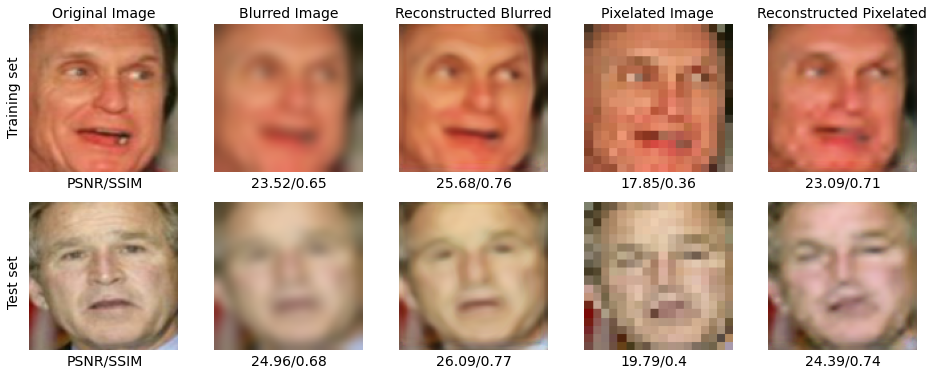

In [ ]:
# Pixel Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred1, test_pred_blurred1, train_pred_pixelated1, test_pred_pixelated1)

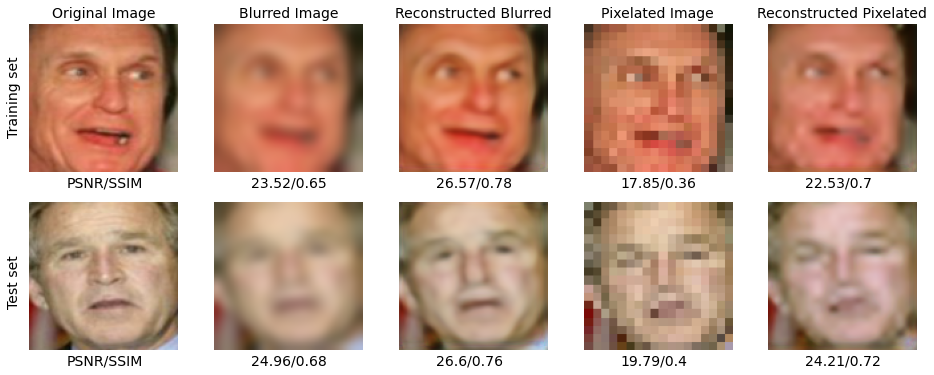

In [ ]:
# L1 Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred2, test_pred_blurred2, train_pred_pixelated2, test_pred_pixelated2)

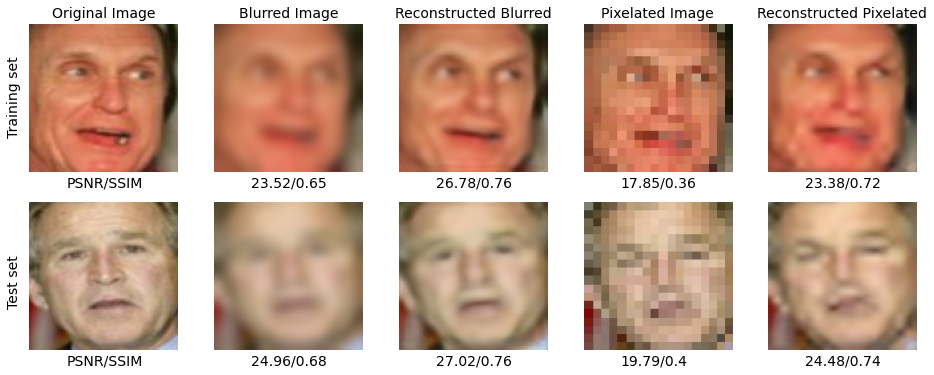

In [ ]:
# PSNR Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred3, test_pred_blurred3, train_pred_pixelated3, test_pred_pixelated3)

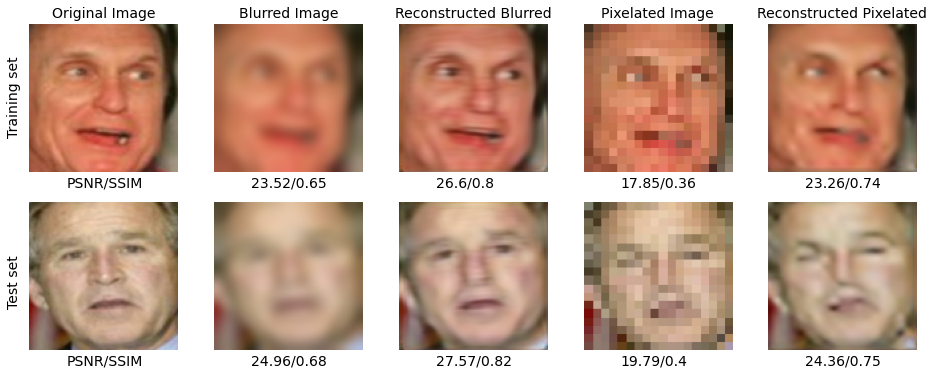

In [ ]:
# SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred4, test_pred_blurred4, train_pred_pixelated4, test_pred_pixelated4)

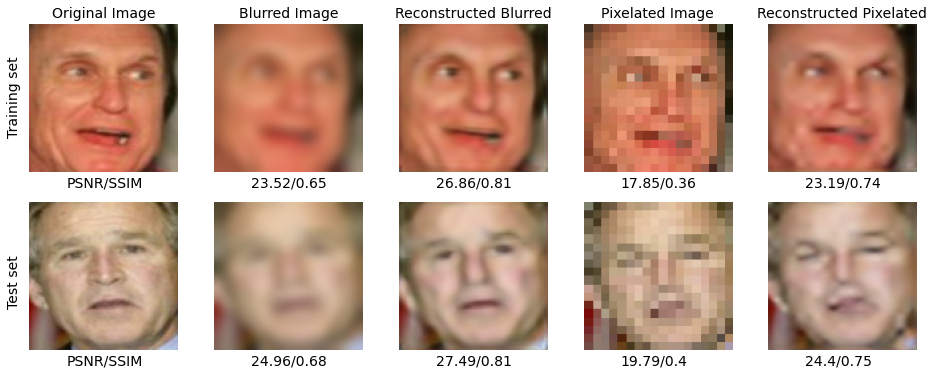

In [ ]:
# PSNR + SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred5, test_pred_blurred5, train_pred_pixelated5, test_pred_pixelated5)

## Losses Plots

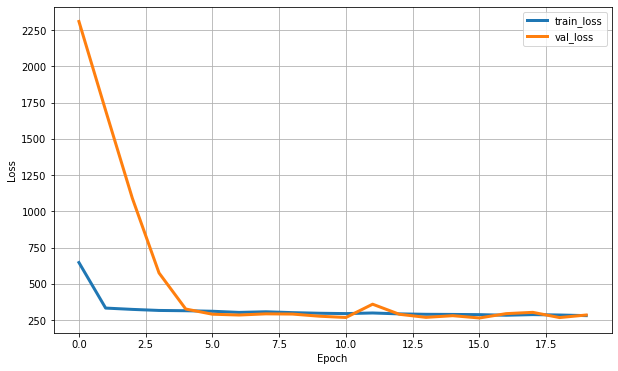

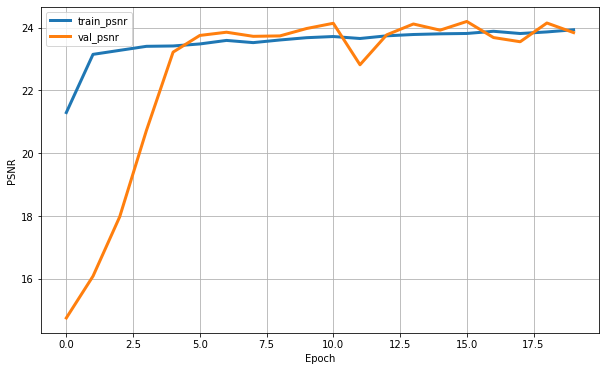

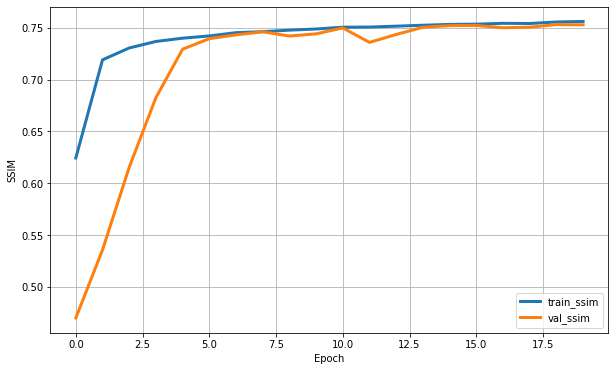

In [ ]:
plot_loss(history_pixelated1)
plot_psnr(history_pixelated1)
plot_ssim(history_pixelated1)

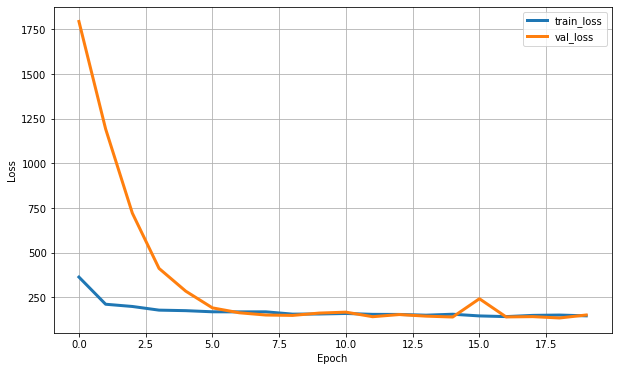

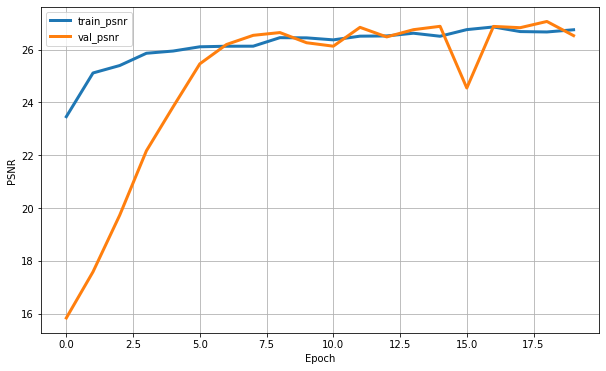

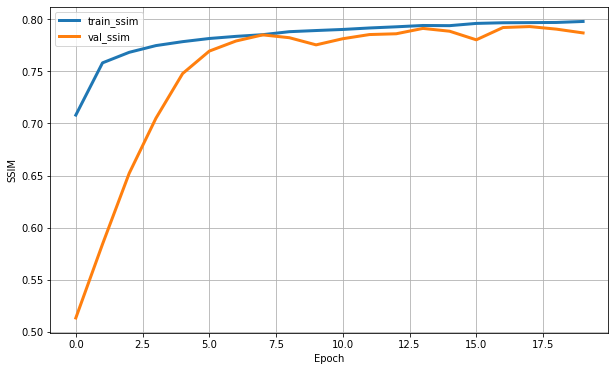

In [ ]:
plot_loss(history_blurred1)
plot_psnr(history_blurred1)
plot_ssim(history_blurred1)

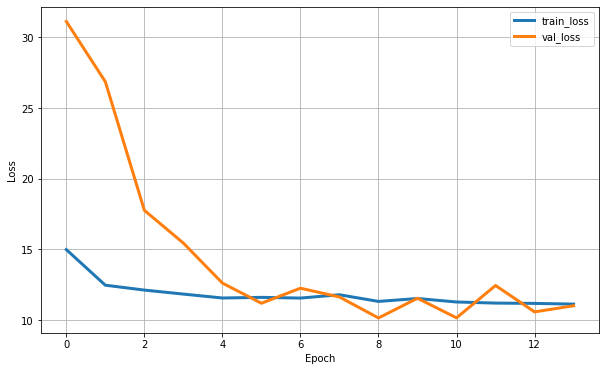

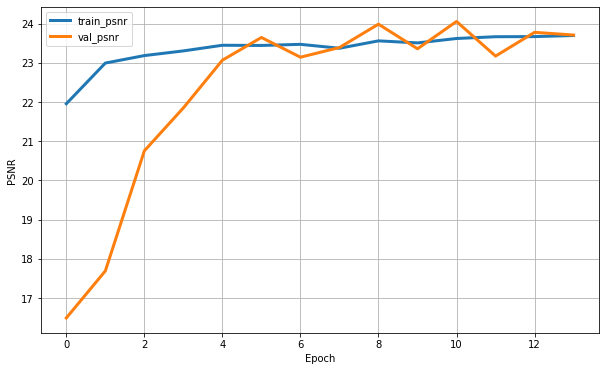

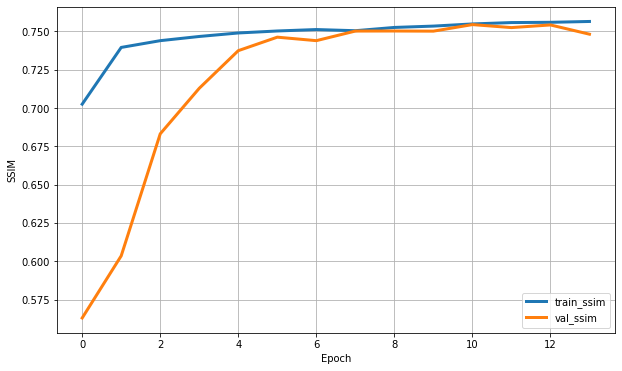

In [ ]:
plot_loss(history_pixelated2)
plot_psnr(history_pixelated2)
plot_ssim(history_pixelated2)

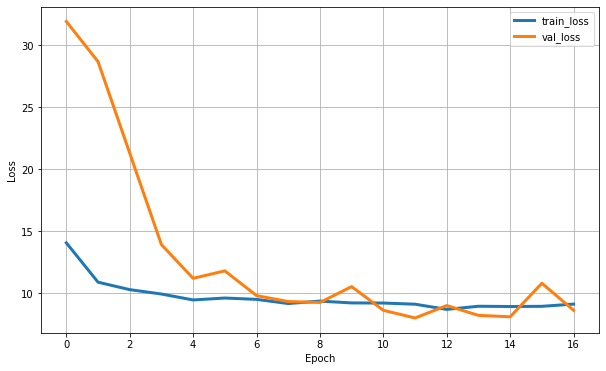

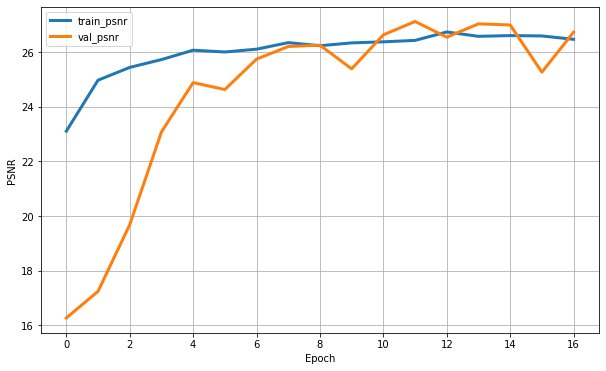

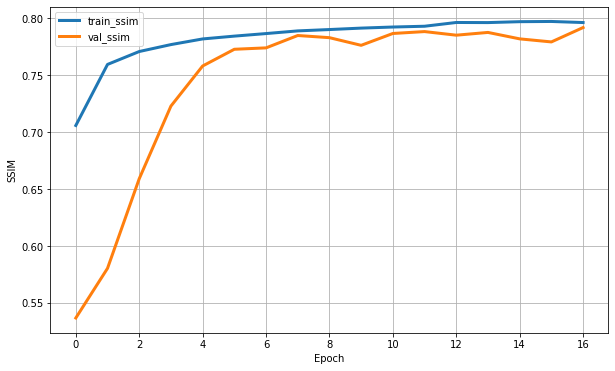

In [ ]:
plot_loss(history_blurred2)
plot_psnr(history_blurred2)
plot_ssim(history_blurred2)

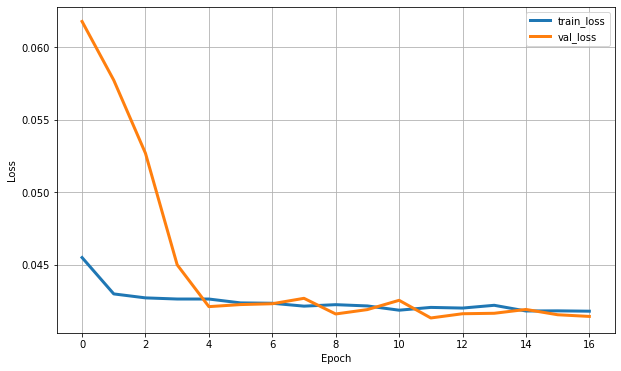

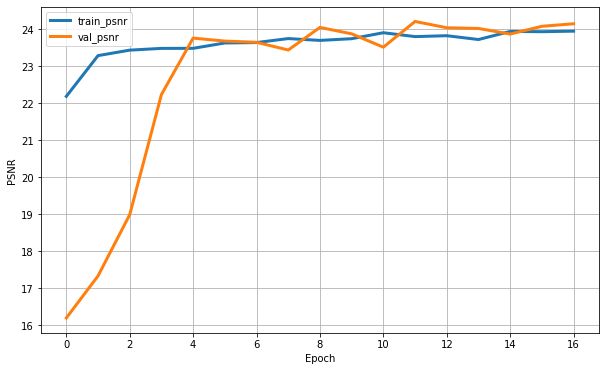

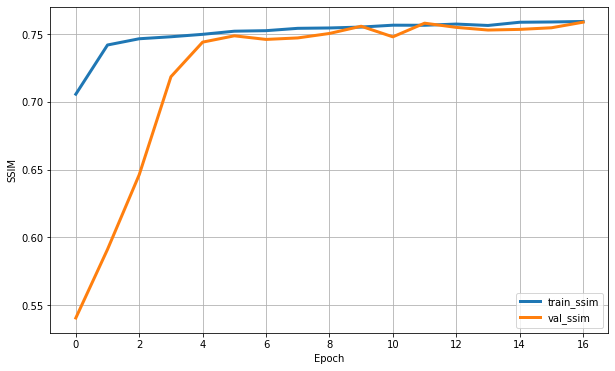

In [ ]:
plot_loss(history_pixelated3)
plot_psnr(history_pixelated3)
plot_ssim(history_pixelated3)

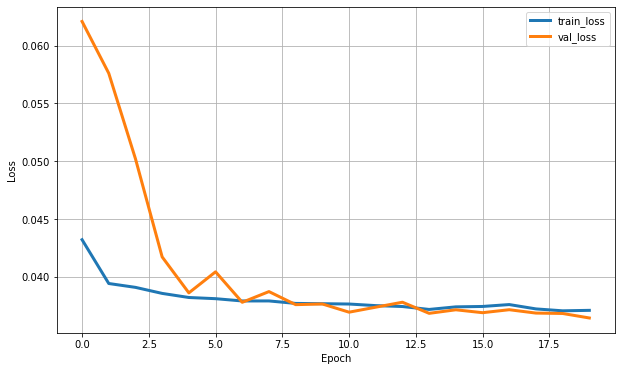

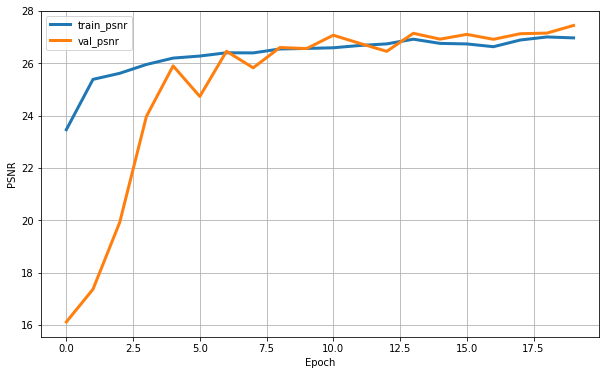

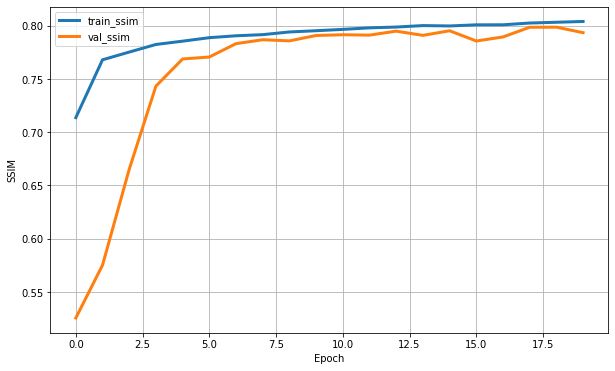

In [ ]:
plot_loss(history_blurred3)
plot_psnr(history_blurred3)
plot_ssim(history_blurred3)

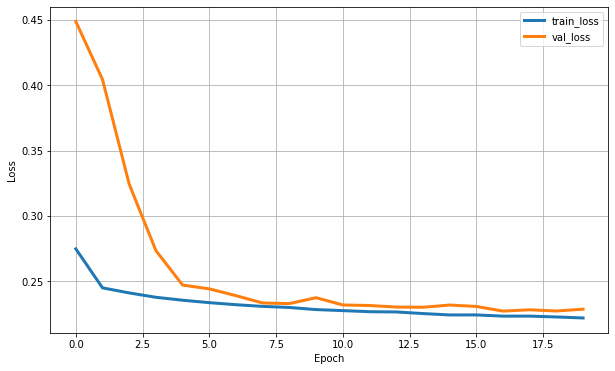

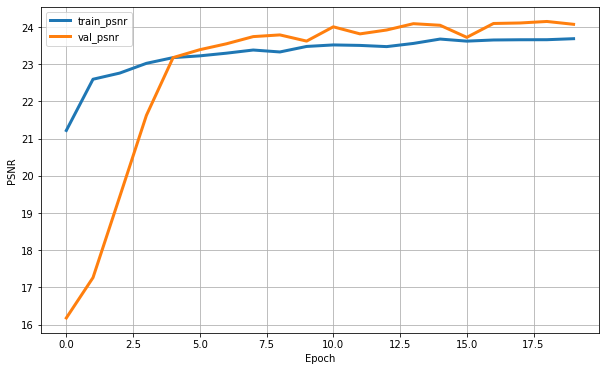

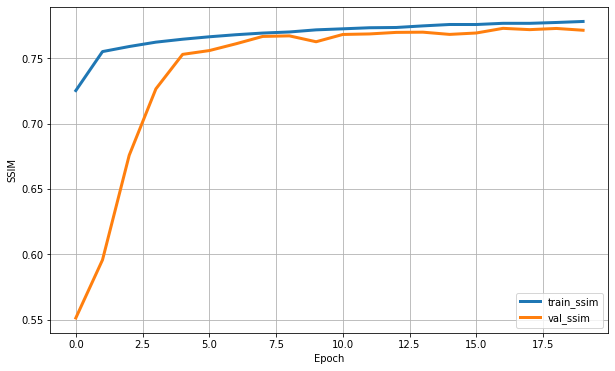

In [ ]:
plot_loss(history_pixelated4)
plot_psnr(history_pixelated4)
plot_ssim(history_pixelated4)

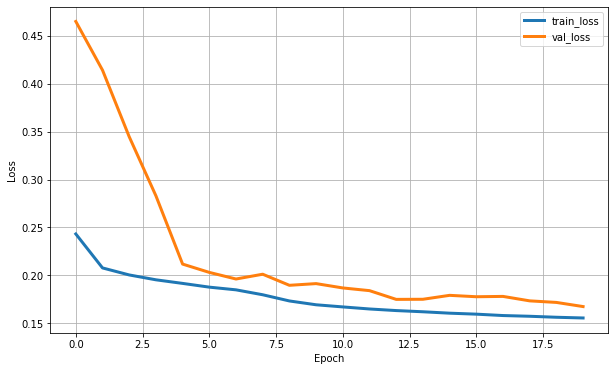

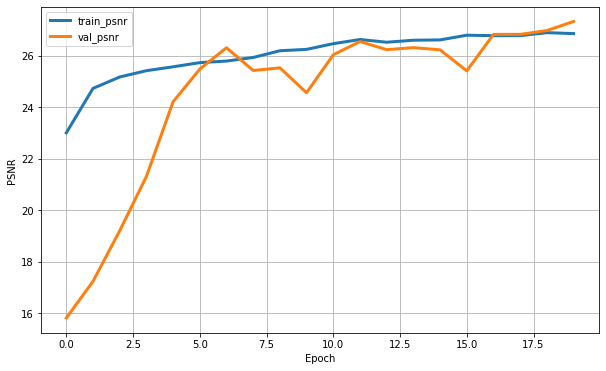

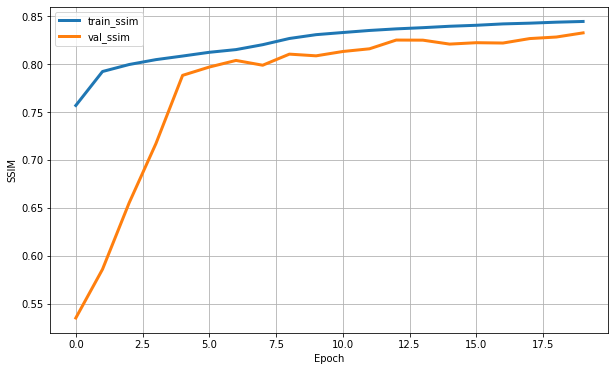

In [ ]:
plot_loss(history_blurred4)
plot_psnr(history_blurred4)
plot_ssim(history_blurred4)

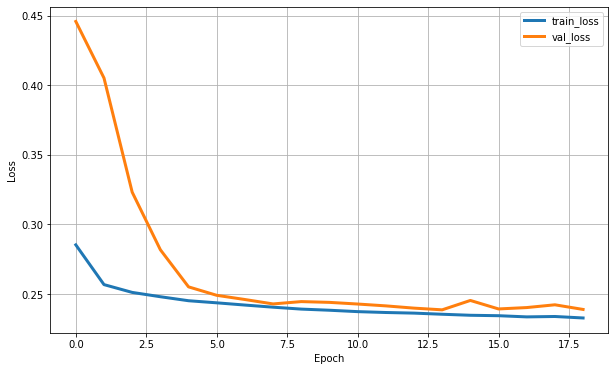

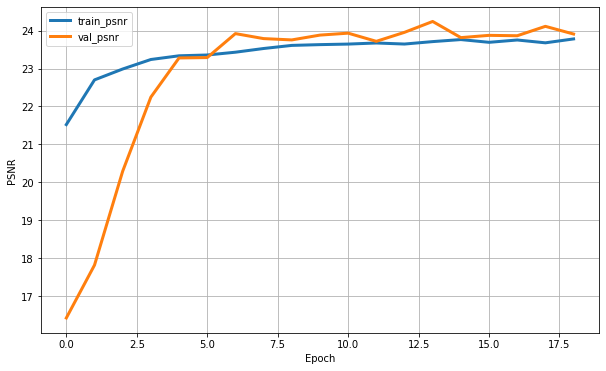

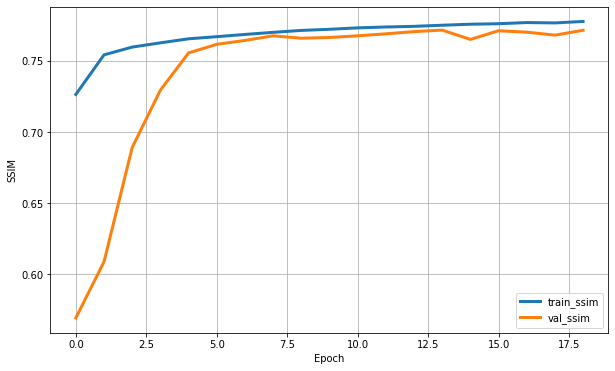

In [ ]:
plot_loss(history_pixelated5)
plot_psnr(history_pixelated5)
plot_ssim(history_pixelated5)

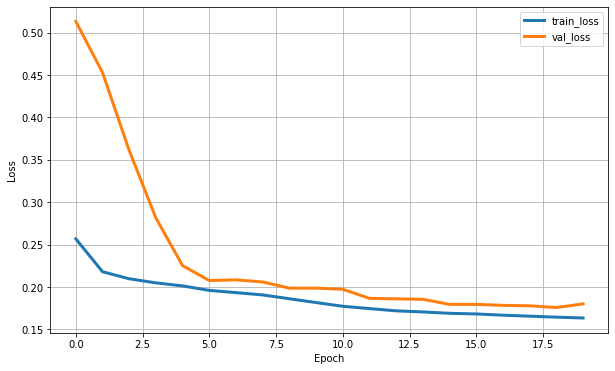

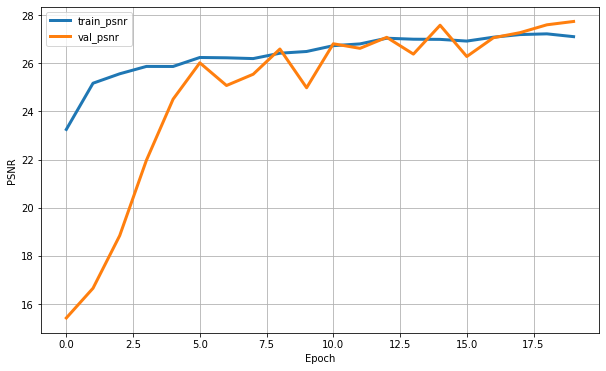

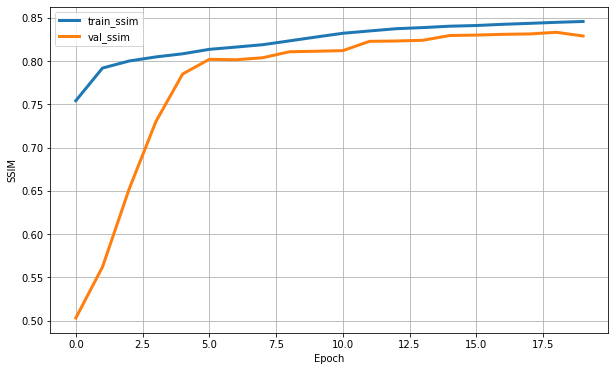

In [ ]:
plot_loss(history_blurred5)
plot_psnr(history_blurred5)
plot_ssim(history_blurred5)

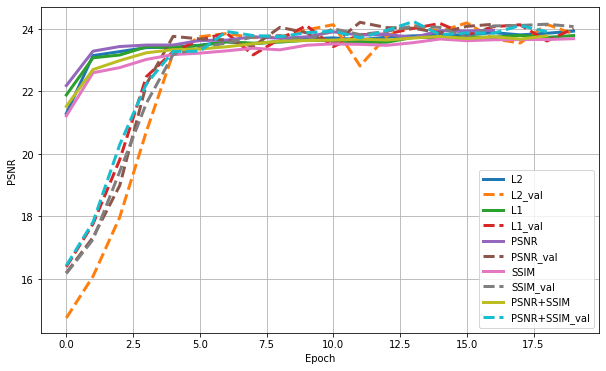

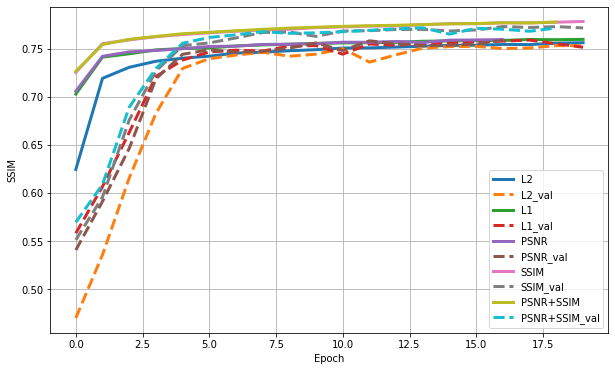

In [ ]:
plot_all_psnr(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)
plot_all_ssim(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)

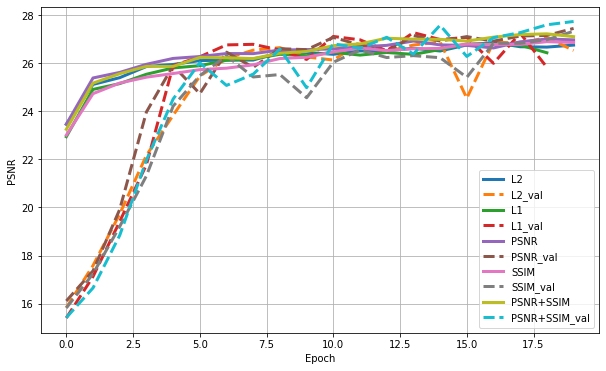

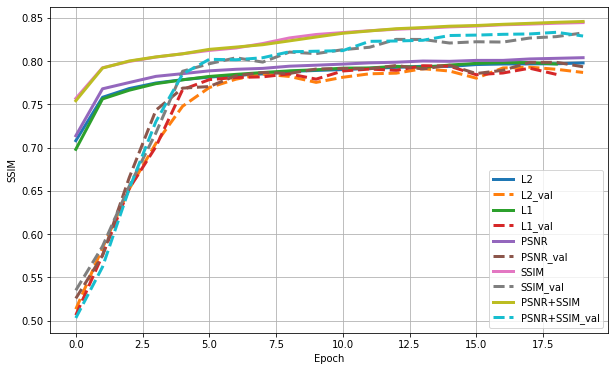

In [ ]:
plot_all_psnr(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)
plot_all_ssim(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)

# Residual Network

## MSE Loss (L2)

In [ ]:
model_pixelated = build_model2()
model_pixelated.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
# Train the model
history_pixelated1 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated1 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated1 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 40s 304ms/step - loss: 631.0605 - psnr: 21.3140 - ssim: 0.6698 - val_loss: 1892.9995 - val_psnr: 15.6385 - val_ssim: 0.5020
Epoch 2/20
125/125 [==============================] - 35s 283ms/step - loss: 360.8230 - psnr: 22.8338 - ssim: 0.7271 - val_loss: 1567.1353 - val_psnr: 16.4188 - val_ssim: 0.5495
Epoch 3/20
125/125 [==============================] - 38s 305ms/step - loss: 327.0578 - psnr: 23.2602 - ssim: 0.7367 - val_loss: 998.0445 - val_psnr: 18.3639 - val_ssim: 0.6326
Epoch 4/20
125/125 [==============================] - 38s 307ms/step - loss: 312.3093 - psnr: 23.4587 - ssim: 0.7423 - val_loss: 587.9550 - val_psnr: 20.6379 - val_ssim: 0.6916
Epoch 5/20
125/125 [==============================] - 36s 289ms/step - loss: 307.5531 - psnr: 23.5358 - ssim: 0.7456 - val_loss: 344.1422 - val_psnr: 23.0157 - val_ssim: 0.7296
Epoch 6/20
125/125 [==============================] - 36s 289ms/step - loss: 306.4138 - psnr: 23.5454 - ssim: 0.7

In [ ]:
model_blurred = build_model2()
model_blurred.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
history_blurred1 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred1 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred1 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 41s 313ms/step - loss: 513.0695 - psnr: 22.3841 - ssim: 0.6834 - val_loss: 1934.0773 - val_psnr: 15.5474 - val_ssim: 0.5081
Epoch 2/20
125/125 [==============================] - 38s 307ms/step - loss: 228.8827 - psnr: 24.7847 - ssim: 0.7552 - val_loss: 1594.0602 - val_psnr: 16.3615 - val_ssim: 0.5407
Epoch 3/20
125/125 [==============================] - 38s 306ms/step - loss: 196.5621 - psnr: 25.4778 - ssim: 0.7699 - val_loss: 1010.9249 - val_psnr: 18.3281 - val_ssim: 0.6288
Epoch 4/20
125/125 [==============================] - 38s 307ms/step - loss: 186.1307 - psnr: 25.6807 - ssim: 0.7761 - val_loss: 467.7717 - val_psnr: 21.6060 - val_ssim: 0.7067
Epoch 5/20
125/125 [==============================] - 36s 288ms/step - loss: 181.0953 - psnr: 25.8111 - ssim: 0.7810 - val_loss: 313.1980 - val_psnr: 23.3419 - val_ssim: 0.7520
Epoch 6/20
125/125 [==============================] - 36s 289ms/step - loss: 171.7941 - psnr: 26.0887 - ssim: 0.

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 11s - loss: 110.4355 - psnr: 27.9575 - ssim: 0.8101 - 11s/epoch - 180ms/step
16/16 - 3s - loss: 117.2700 - psnr: 27.7065 - ssim: 0.8000 - 3s/epoch - 178ms/step
63/63 - 11s - loss: 253.3766 - psnr: 24.3446 - ssim: 0.7650 - 11s/epoch - 181ms/step
16/16 - 3s - loss: 268.7611 - psnr: 24.1000 - ssim: 0.7555 - 3s/epoch - 179ms/step


## MAE Loss (L1)

In [ ]:
model_pixelated = build_model2()
model_pixelated.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_pixelated2 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated2 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated2 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 42s 314ms/step - loss: 17.4169 - psnr: 20.9043 - ssim: 0.6787 - val_loss: 35.2111 - val_psnr: 15.4682 - val_ssim: 0.4986
Epoch 2/20
125/125 [==============================] - 38s 306ms/step - loss: 13.0856 - psnr: 22.6116 - ssim: 0.7352 - val_loss: 31.7540 - val_psnr: 16.4431 - val_ssim: 0.5540
Epoch 3/20
125/125 [==============================] - 38s 307ms/step - loss: 11.9128 - psnr: 23.2456 - ssim: 0.7479 - val_loss: 25.6887 - val_psnr: 18.1668 - val_ssim: 0.6244
Epoch 4/20
125/125 [==============================] - 36s 288ms/step - loss: 11.3432 - psnr: 23.5522 - ssim: 0.7546 - val_loss: 19.9411 - val_psnr: 20.2423 - val_ssim: 0.6910
Epoch 5/20
125/125 [==============================] - 36s 288ms/step - loss: 11.5774 - psnr: 23.4796 - ssim: 0.7577 - val_loss: 12.1657 - val_psnr: 23.3248 - val_ssim: 0.7447
Epoch 6/20
125/125 [==============================] - 36s 288ms/step - loss: 11.2996 - psnr: 23.6435 - ssim: 0.7608 - val_los

In [ ]:
model_blurred = build_model2()
model_blurred.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_blurred2 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred2 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred2 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 39s 297ms/step - loss: 16.0143 - psnr: 22.2753 - ssim: 0.6859 - val_loss: 35.8292 - val_psnr: 15.3756 - val_ssim: 0.4883
Epoch 2/20
125/125 [==============================] - 36s 288ms/step - loss: 11.0365 - psnr: 24.8540 - ssim: 0.7600 - val_loss: 31.4613 - val_psnr: 16.5945 - val_ssim: 0.5637
Epoch 3/20
125/125 [==============================] - 36s 288ms/step - loss: 9.9740 - psnr: 25.6683 - ssim: 0.7770 - val_loss: 24.9351 - val_psnr: 18.4178 - val_ssim: 0.6345
Epoch 4/20
125/125 [==============================] - 36s 289ms/step - loss: 9.8858 - psnr: 25.7849 - ssim: 0.7819 - val_loss: 18.8180 - val_psnr: 20.9638 - val_ssim: 0.7072
Epoch 5/20
125/125 [==============================] - 36s 288ms/step - loss: 9.4593 - psnr: 26.1200 - ssim: 0.7886 - val_loss: 16.0533 - val_psnr: 22.0174 - val_ssim: 0.7463
Epoch 6/20
125/125 [==============================] - 36s 289ms/step - loss: 9.5819 - psnr: 26.0905 - ssim: 0.7904 - val_loss: 1

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 11s - loss: 8.1041 - psnr: 27.3167 - ssim: 0.8171 - 11s/epoch - 180ms/step
16/16 - 3s - loss: 8.2668 - psnr: 27.1332 - ssim: 0.8076 - 3s/epoch - 179ms/step
63/63 - 11s - loss: 10.2996 - psnr: 24.1818 - ssim: 0.7813 - 11s/epoch - 180ms/step
16/16 - 3s - loss: 10.5141 - psnr: 24.0060 - ssim: 0.7729 - 3s/epoch - 179ms/step


## PSNR Loss

In [ ]:
model_pixelated = build_model2()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_pixelated3 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated3 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated3 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 41s 313ms/step - loss: 0.0487 - psnr: 20.9937 - ssim: 0.6741 - val_loss: 0.0639 - val_psnr: 15.6538 - val_ssim: 0.5117
Epoch 2/20
125/125 [==============================] - 36s 288ms/step - loss: 0.0436 - psnr: 22.9762 - ssim: 0.7340 - val_loss: 0.0619 - val_psnr: 16.1550 - val_ssim: 0.5452
Epoch 3/20
125/125 [==============================] - 38s 307ms/step - loss: 0.0430 - psnr: 23.2774 - ssim: 0.7425 - val_loss: 0.0558 - val_psnr: 17.9206 - val_ssim: 0.6179
Epoch 4/20
125/125 [==============================] - 38s 306ms/step - loss: 0.0426 - psnr: 23.4942 - ssim: 0.7479 - val_loss: 0.0478 - val_psnr: 20.9381 - val_ssim: 0.7000
Epoch 5/20
125/125 [==============================] - 38s 306ms/step - loss: 0.0426 - psnr: 23.5182 - ssim: 0.7510 - val_loss: 0.0425 - val_psnr: 23.5417 - val_ssim: 0.7382
Epoch 6/20
125/125 [==============================] - 36s 288ms/step - loss: 0.0422 - psnr: 23.6960 - ssim: 0.7550 - val_loss: 0.0422 -

1/1 [==============================] - 0s 22ms/step


In [ ]:
model_blurred = build_model2()
model_blurred.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_blurred3 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred3 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred3 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 42s 314ms/step - loss: 0.0449 - psnr: 22.7324 - ssim: 0.7041 - val_loss: 0.0652 - val_psnr: 15.3554 - val_ssim: 0.4872
Epoch 2/20
125/125 [==============================] - 38s 306ms/step - loss: 0.0399 - psnr: 25.1124 - ssim: 0.7695 - val_loss: 0.0597 - val_psnr: 16.7657 - val_ssim: 0.5578
Epoch 3/20
125/125 [==============================] - 36s 289ms/step - loss: 0.0389 - psnr: 25.7574 - ssim: 0.7807 - val_loss: 0.0563 - val_psnr: 17.7749 - val_ssim: 0.6237
Epoch 4/20
125/125 [==============================] - 36s 289ms/step - loss: 0.0385 - psnr: 25.9976 - ssim: 0.7863 - val_loss: 0.0463 - val_psnr: 21.6117 - val_ssim: 0.7198
Epoch 5/20
125/125 [==============================] - 36s 288ms/step - loss: 0.0381 - psnr: 26.2964 - ssim: 0.7917 - val_loss: 0.0421 - val_psnr: 23.7387 - val_ssim: 0.7653
Epoch 6/20
125/125 [==============================] - 38s 306ms/step - loss: 0.0377 - psnr: 26.5428 - ssim: 0.7958 - val_loss: 0.0383 -

1/1 [==============================] - 0s 21ms/step


In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 11s - loss: 0.0355 - psnr: 28.1864 - ssim: 0.8380 - 11s/epoch - 181ms/step
16/16 - 3s - loss: 0.0358 - psnr: 27.9722 - ssim: 0.8301 - 3s/epoch - 180ms/step
63/63 - 11s - loss: 0.0409 - psnr: 24.4730 - ssim: 0.7748 - 11s/epoch - 181ms/step
16/16 - 3s - loss: 0.0413 - psnr: 24.2071 - ssim: 0.7652 - 3s/epoch - 180ms/step


## SSIM Loss

In [ ]:
model_pixelated = build_model2()
model_pixelated.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_pixelated4 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated4 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated4 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 40s 302ms/step - loss: 0.2867 - psnr: 20.6633 - ssim: 0.7133 - val_loss: 0.4461 - val_psnr: 16.3482 - val_ssim: 0.5539
Epoch 2/20
125/125 [==============================] - 39s 309ms/step - loss: 0.2355 - psnr: 22.6165 - ssim: 0.7645 - val_loss: 0.3944 - val_psnr: 17.4159 - val_ssim: 0.6056
Epoch 3/20
125/125 [==============================] - 39s 311ms/step - loss: 0.2266 - psnr: 23.1360 - ssim: 0.7734 - val_loss: 0.3259 - val_psnr: 19.2815 - val_ssim: 0.6741
Epoch 4/20
125/125 [==============================] - 37s 293ms/step - loss: 0.2216 - psnr: 23.3225 - ssim: 0.7784 - val_loss: 0.2739 - val_psnr: 20.8595 - val_ssim: 0.7261
Epoch 5/20
125/125 [==============================] - 39s 310ms/step - loss: 0.2185 - psnr: 23.4128 - ssim: 0.7815 - val_loss: 0.2388 - val_psnr: 22.8774 - val_ssim: 0.7612
Epoch 6/20
125/125 [==============================] - 37s 293ms/step - loss: 0.2154 - psnr: 23.4957 - ssim: 0.7846 - val_loss: 0.2232 -

In [ ]:
model_blurred = build_model2()
model_blurred.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_blurred4 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred4 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred4 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 40s 299ms/step - loss: 0.2557 - psnr: 21.9002 - ssim: 0.7443 - val_loss: 0.4774 - val_psnr: 15.8670 - val_ssim: 0.5226
Epoch 2/20
125/125 [==============================] - 37s 292ms/step - loss: 0.2002 - psnr: 24.5804 - ssim: 0.7998 - val_loss: 0.4174 - val_psnr: 16.9036 - val_ssim: 0.5826
Epoch 3/20
125/125 [==============================] - 36s 291ms/step - loss: 0.1867 - psnr: 25.1619 - ssim: 0.8133 - val_loss: 0.3682 - val_psnr: 18.1568 - val_ssim: 0.6318
Epoch 4/20
125/125 [==============================] - 36s 292ms/step - loss: 0.1636 - psnr: 25.8236 - ssim: 0.8364 - val_loss: 0.2889 - val_psnr: 19.7198 - val_ssim: 0.7111
Epoch 5/20
125/125 [==============================] - 39s 309ms/step - loss: 0.1523 - psnr: 25.9254 - ssim: 0.8477 - val_loss: 0.1979 - val_psnr: 22.9892 - val_ssim: 0.8021
Epoch 6/20
125/125 [==============================] - 39s 309ms/step - loss: 0.1429 - psnr: 26.4245 - ssim: 0.8571 - val_loss: 0.1537 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 12s - loss: 0.1122 - psnr: 28.5495 - ssim: 0.8878 - 12s/epoch - 183ms/step
16/16 - 3s - loss: 0.1194 - psnr: 28.4434 - ssim: 0.8806 - 3s/epoch - 182ms/step
63/63 - 12s - loss: 0.1948 - psnr: 24.5532 - ssim: 0.8052 - 12s/epoch - 183ms/step
16/16 - 3s - loss: 0.2159 - psnr: 24.2078 - ssim: 0.7841 - 3s/epoch - 182ms/step


## PSNR + SSIM Loss

In [ ]:
model_pixelated = build_model2()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_pixelated5 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated5 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated5 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 43s 303ms/step - loss: 0.2965 - psnr: 20.7644 - ssim: 0.7158 - val_loss: 0.4750 - val_psnr: 16.0537 - val_ssim: 0.5406
Epoch 2/20
125/125 [==============================] - 39s 309ms/step - loss: 0.2452 - psnr: 22.8591 - ssim: 0.7657 - val_loss: 0.4221 - val_psnr: 16.9725 - val_ssim: 0.5926
Epoch 3/20
125/125 [==============================] - 37s 293ms/step - loss: 0.2368 - psnr: 23.2363 - ssim: 0.7739 - val_loss: 0.3507 - val_psnr: 18.9547 - val_ssim: 0.6625
Epoch 4/20
125/125 [==============================] - 36s 292ms/step - loss: 0.2313 - psnr: 23.4140 - ssim: 0.7794 - val_loss: 0.2900 - val_psnr: 20.9462 - val_ssim: 0.7219
Epoch 5/20
125/125 [==============================] - 39s 310ms/step - loss: 0.2269 - psnr: 23.6684 - ssim: 0.7837 - val_loss: 0.2565 - val_psnr: 22.1381 - val_ssim: 0.7548
Epoch 6/20
125/125 [==============================] - 37s 293ms/step - loss: 0.2237 - psnr: 23.7570 - ssim: 0.7868 - val_loss: 0.2330 -

In [ ]:
model_blurred = build_model2()
model_blurred.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_blurred5 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred5 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred5 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 42s 318ms/step - loss: 0.2632 - psnr: 22.4011 - ssim: 0.7482 - val_loss: 0.4960 - val_psnr: 15.7244 - val_ssim: 0.5199
Epoch 2/20
125/125 [==============================] - 39s 310ms/step - loss: 0.2136 - psnr: 24.5959 - ssim: 0.7966 - val_loss: 0.4557 - val_psnr: 16.2251 - val_ssim: 0.5597
Epoch 3/20
125/125 [==============================] - 39s 309ms/step - loss: 0.2028 - psnr: 25.1498 - ssim: 0.8072 - val_loss: 0.3694 - val_psnr: 18.5236 - val_ssim: 0.6441
Epoch 4/20
125/125 [==============================] - 39s 310ms/step - loss: 0.1905 - psnr: 25.5631 - ssim: 0.8193 - val_loss: 0.2917 - val_psnr: 20.5387 - val_ssim: 0.7205
Epoch 5/20
125/125 [==============================] - 39s 310ms/step - loss: 0.1704 - psnr: 26.3775 - ssim: 0.8391 - val_loss: 0.2306 - val_psnr: 22.8735 - val_ssim: 0.7803
Epoch 6/20
125/125 [==============================] - 39s 310ms/step - loss: 0.1599 - psnr: 26.6090 - ssim: 0.8495 - val_loss: 0.1824 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 12s - loss: 0.1194 - psnr: 29.2775 - ssim: 0.8892 - 12s/epoch - 183ms/step
16/16 - 3s - loss: 0.1269 - psnr: 29.1476 - ssim: 0.8817 - 3s/epoch - 181ms/step
63/63 - 12s - loss: 0.1991 - psnr: 24.9042 - ssim: 0.8109 - 12s/epoch - 183ms/step
16/16 - 3s - loss: 0.2197 - psnr: 24.5279 - ssim: 0.7905 - 3s/epoch - 182ms/step


## Plots

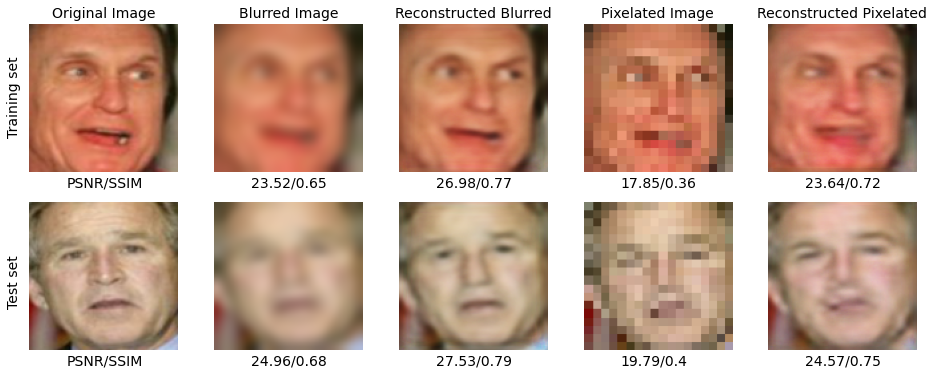

In [ ]:
# Pixel Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred1, test_pred_blurred1, train_pred_pixelated1, test_pred_pixelated1)

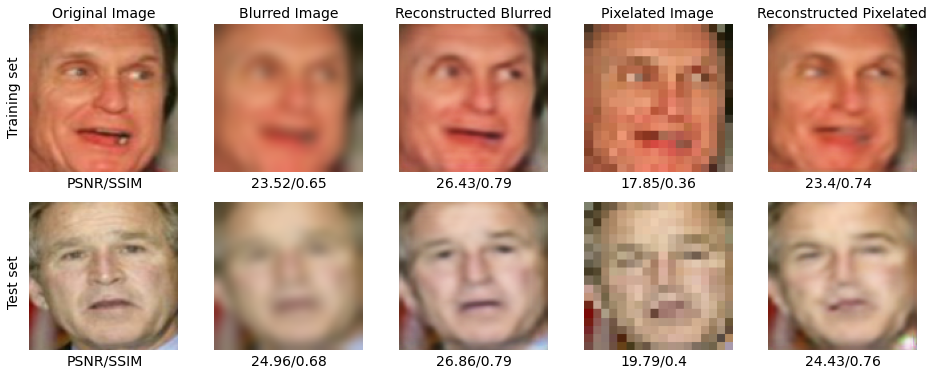

In [ ]:
# L1 Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred2, test_pred_blurred2, train_pred_pixelated2, test_pred_pixelated2)

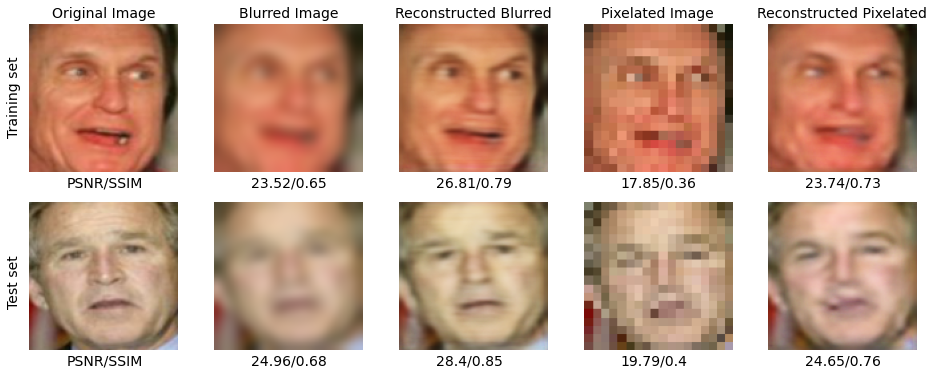

In [ ]:
# PSNR Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred3, test_pred_blurred3, train_pred_pixelated3, test_pred_pixelated3)

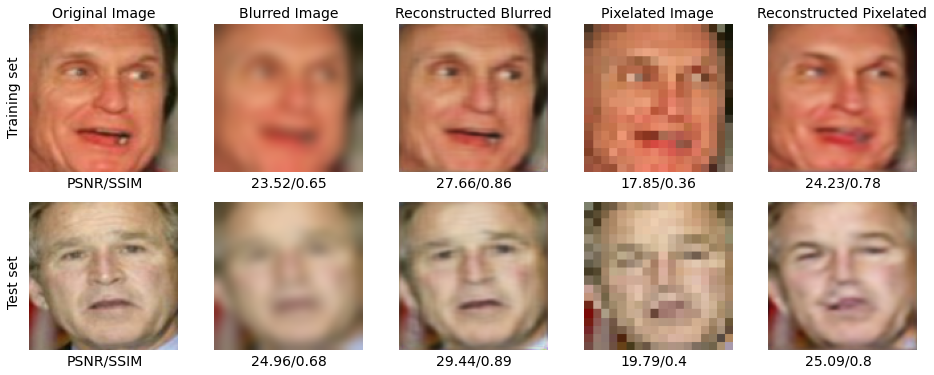

In [ ]:
# SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred4, test_pred_blurred4, train_pred_pixelated4, test_pred_pixelated4)

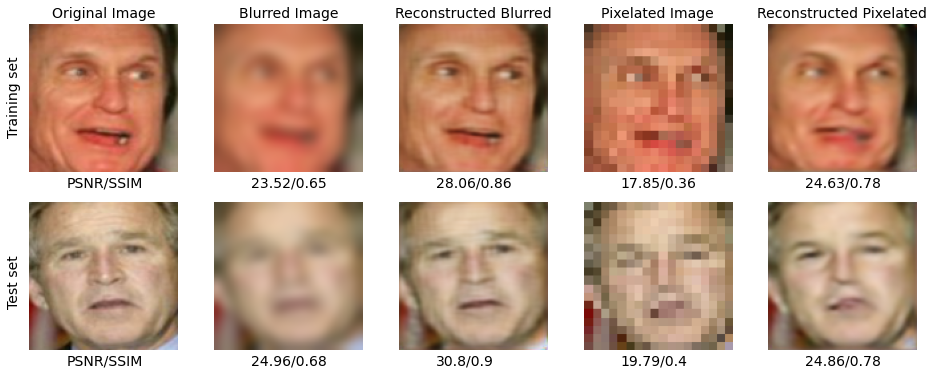

In [ ]:
# PSNR + SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred5, test_pred_blurred5, train_pred_pixelated5, test_pred_pixelated5)

## Losses Plots

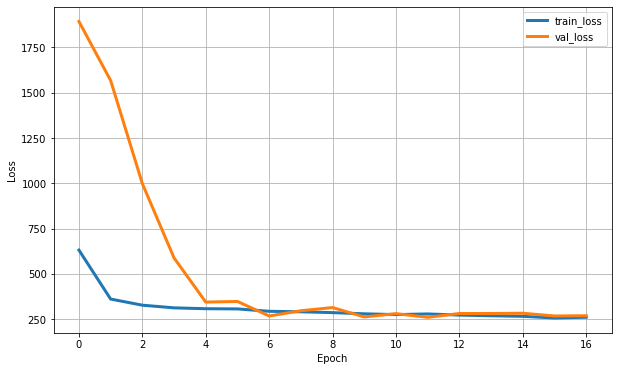

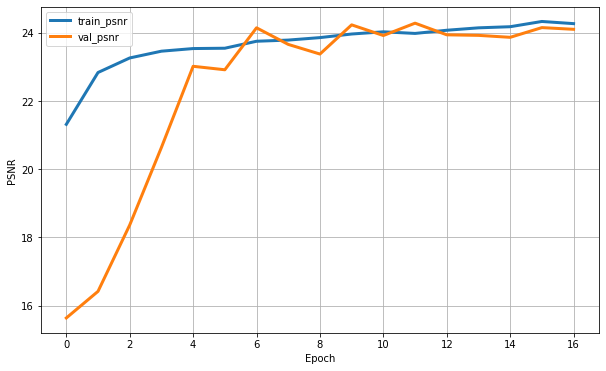

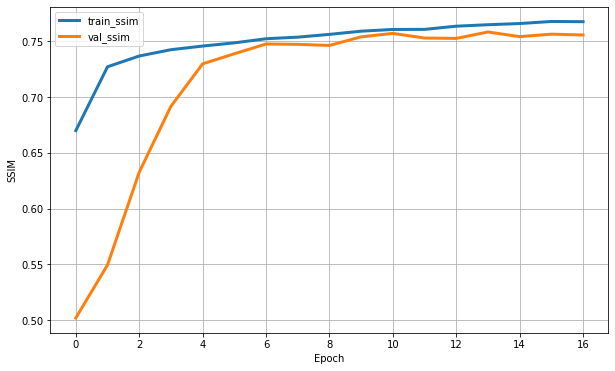

In [ ]:
plot_loss(history_pixelated1)
plot_psnr(history_pixelated1)
plot_ssim(history_pixelated1)

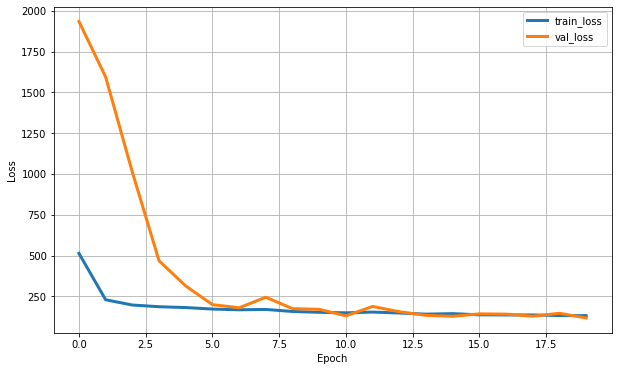

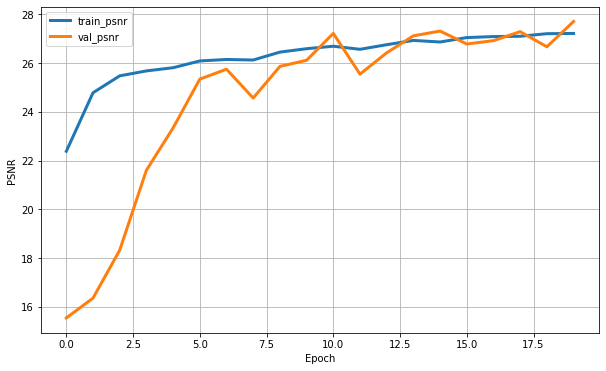

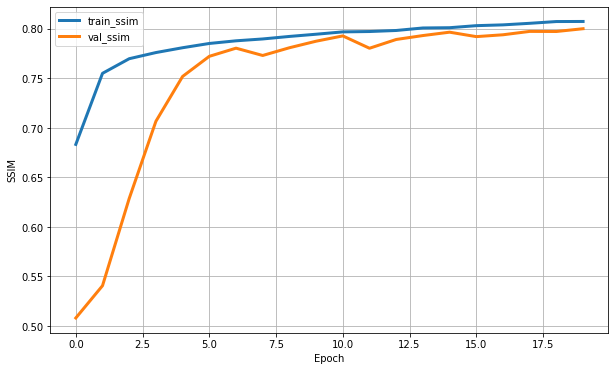

In [ ]:
plot_loss(history_blurred1)
plot_psnr(history_blurred1)
plot_ssim(history_blurred1)

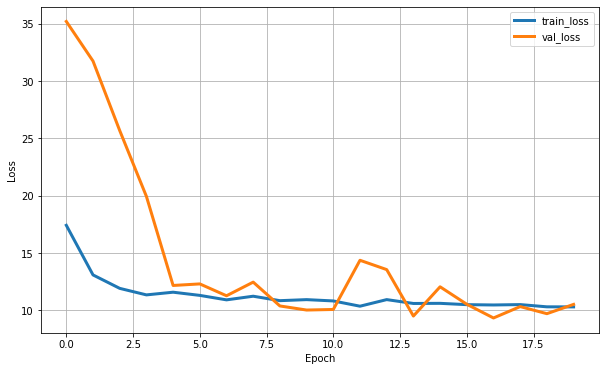

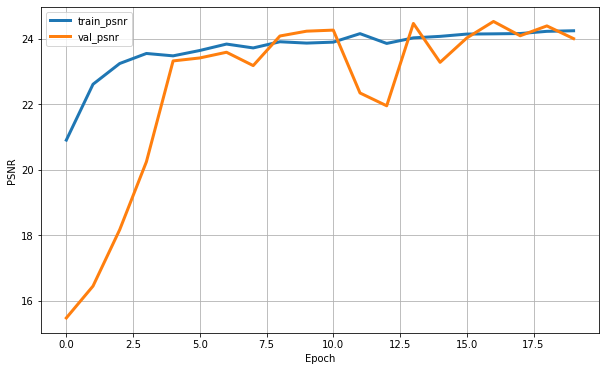

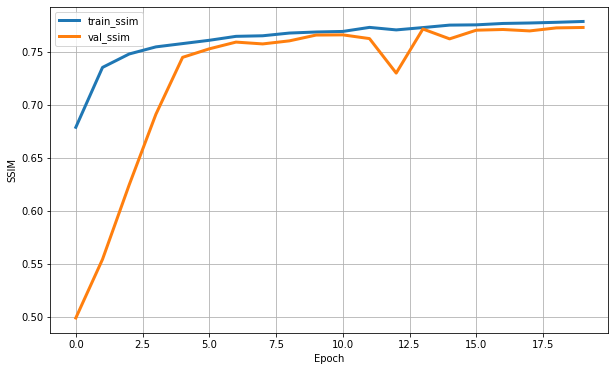

In [ ]:
plot_loss(history_pixelated2)
plot_psnr(history_pixelated2)
plot_ssim(history_pixelated2)

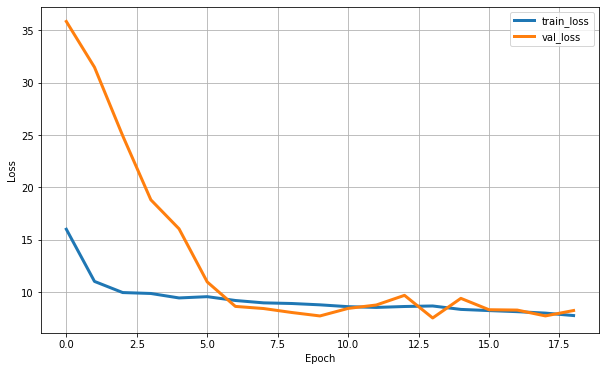

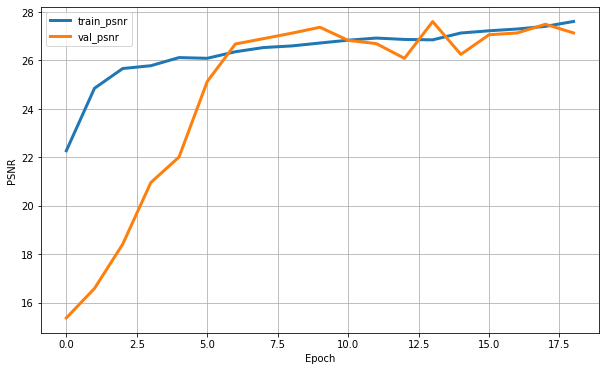

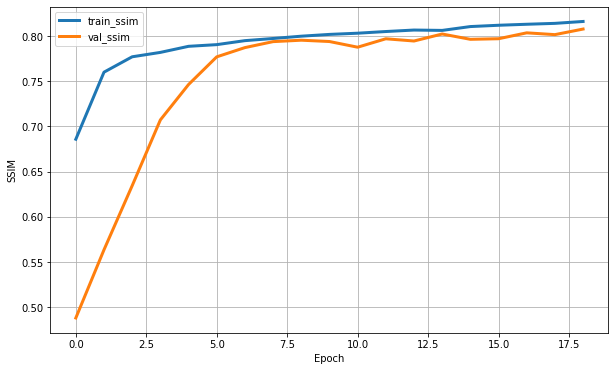

In [ ]:
plot_loss(history_blurred2)
plot_psnr(history_blurred2)
plot_ssim(history_blurred2)

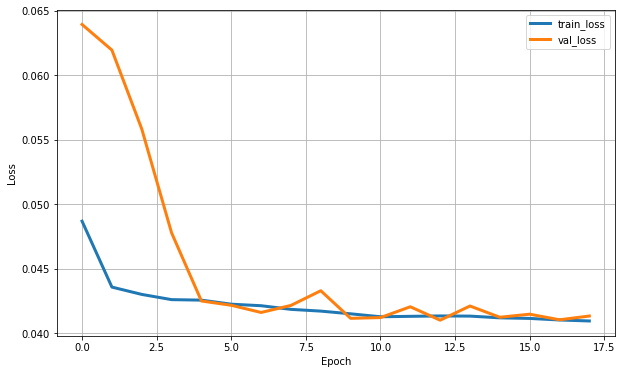

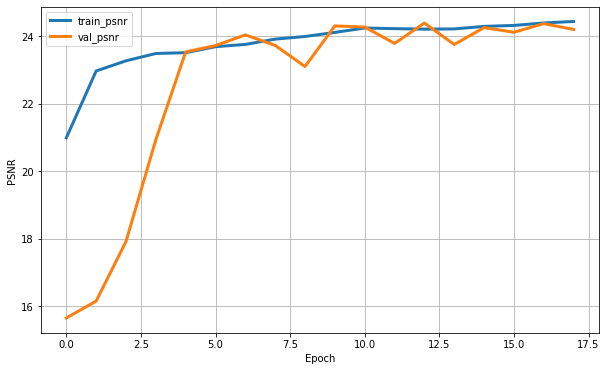

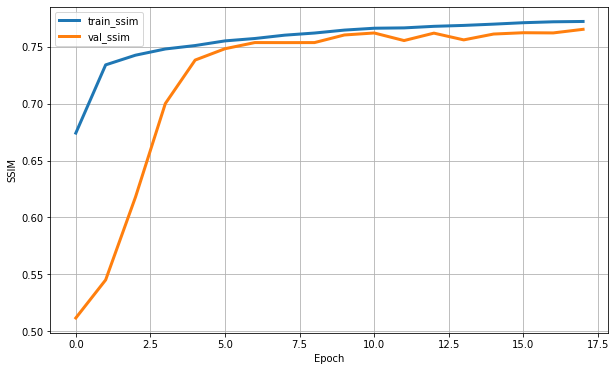

In [ ]:
plot_loss(history_pixelated3)
plot_psnr(history_pixelated3)
plot_ssim(history_pixelated3)

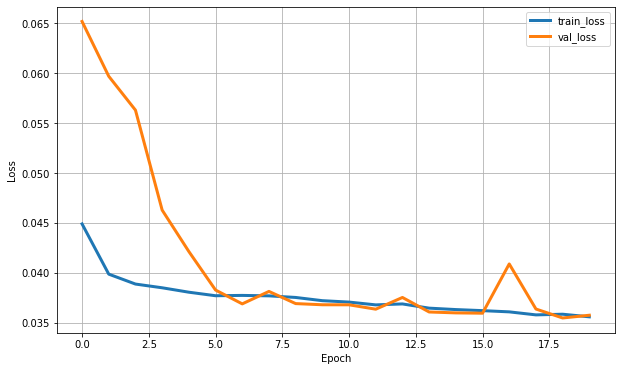

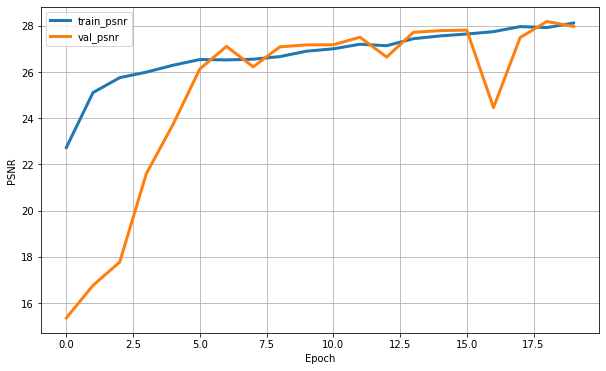

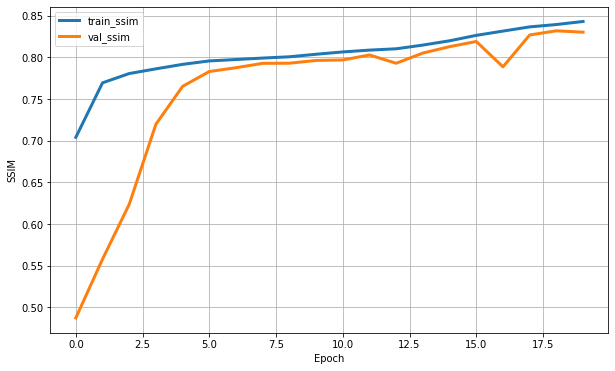

In [ ]:
plot_loss(history_blurred3)
plot_psnr(history_blurred3)
plot_ssim(history_blurred3)

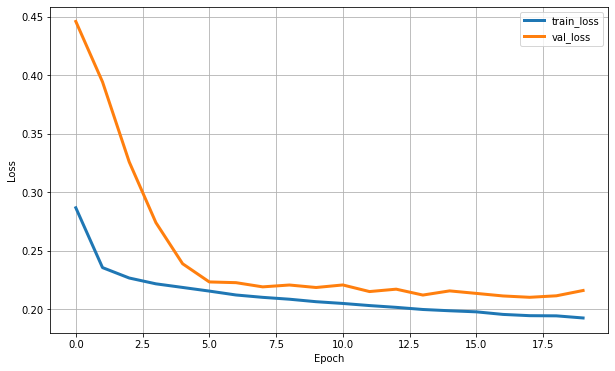

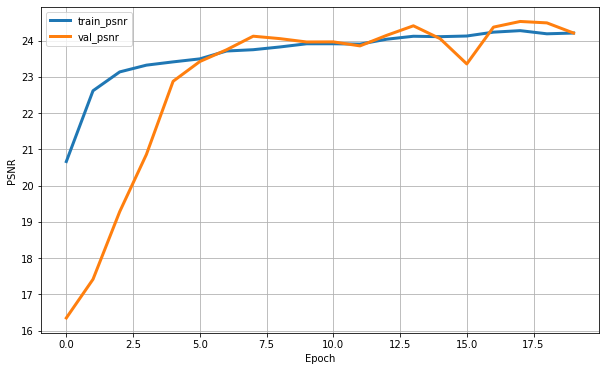

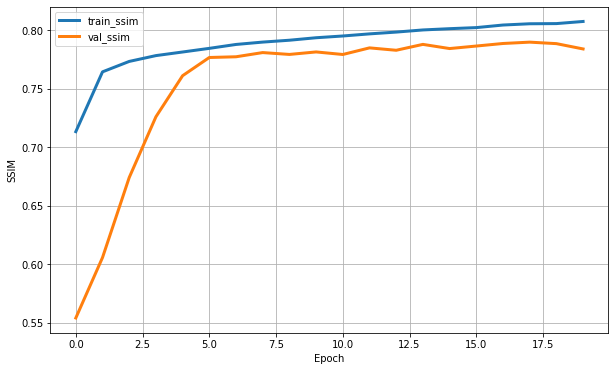

In [ ]:
plot_loss(history_pixelated4)
plot_psnr(history_pixelated4)
plot_ssim(history_pixelated4)

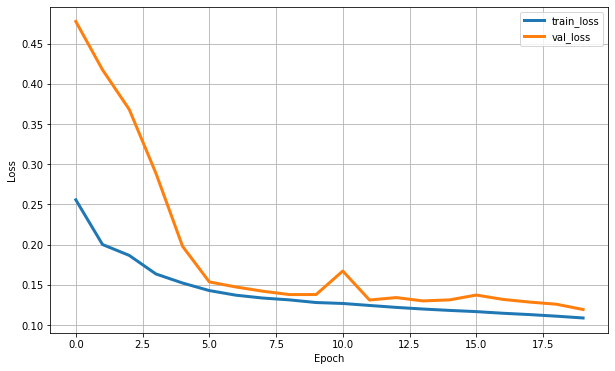

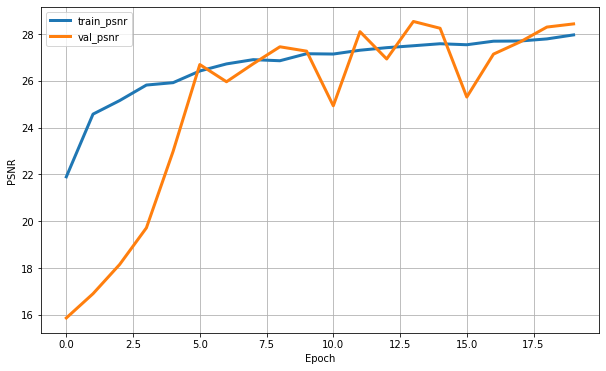

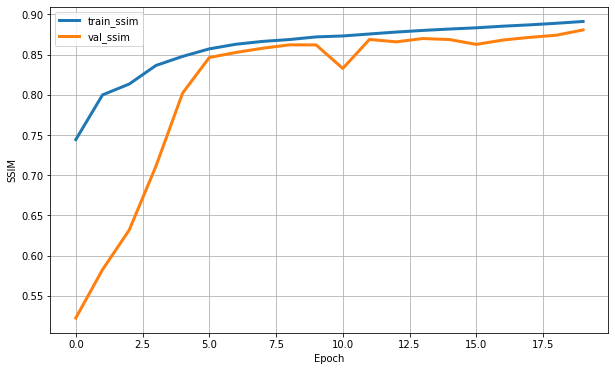

In [ ]:
plot_loss(history_blurred4)
plot_psnr(history_blurred4)
plot_ssim(history_blurred4)

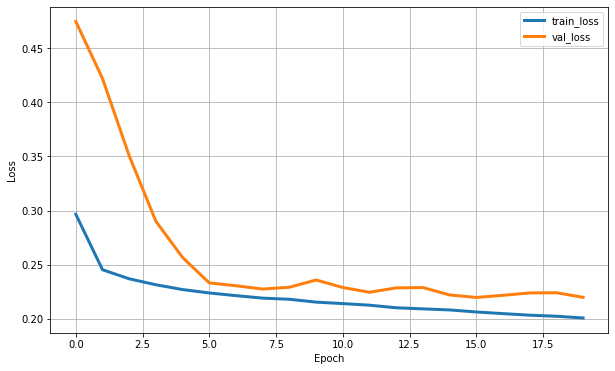

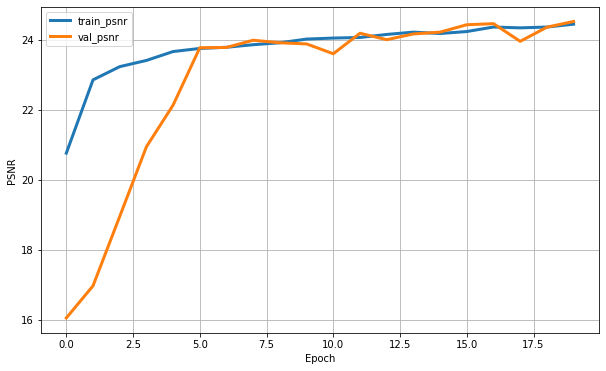

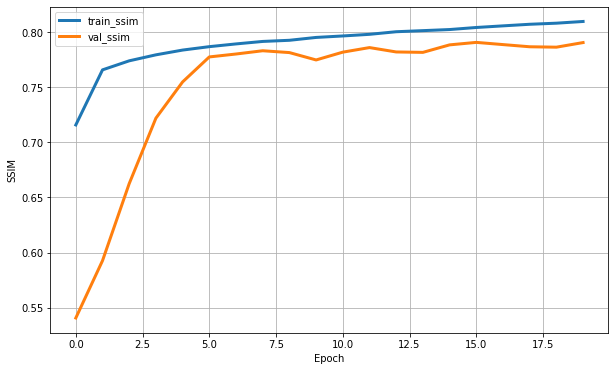

In [ ]:
plot_loss(history_pixelated5)
plot_psnr(history_pixelated5)
plot_ssim(history_pixelated5)

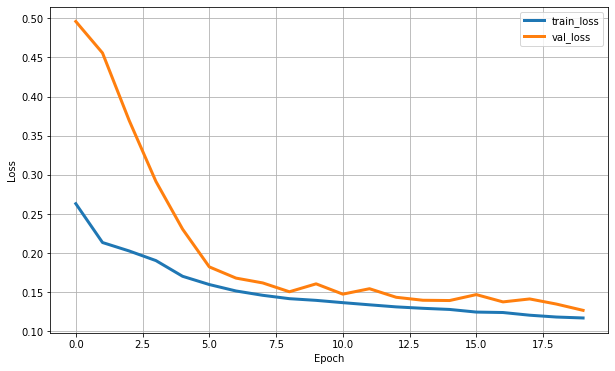

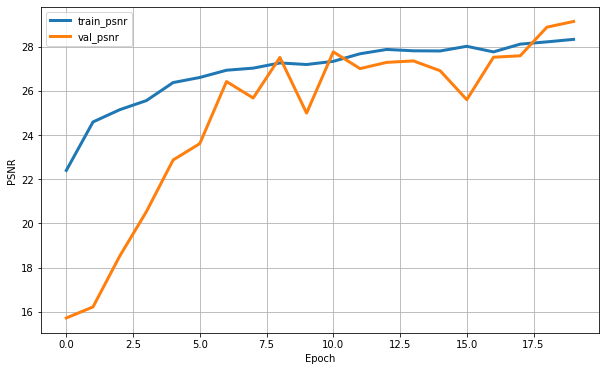

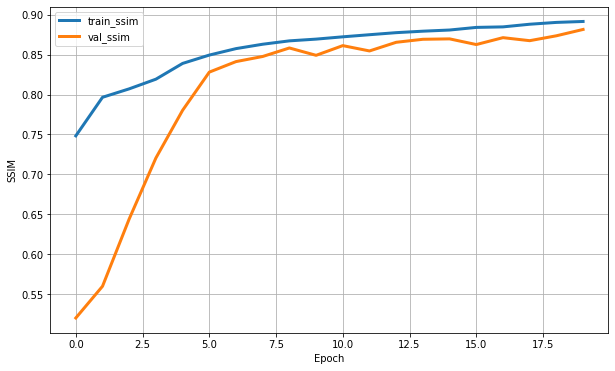

In [ ]:
plot_loss(history_blurred5)
plot_psnr(history_blurred5)
plot_ssim(history_blurred5)

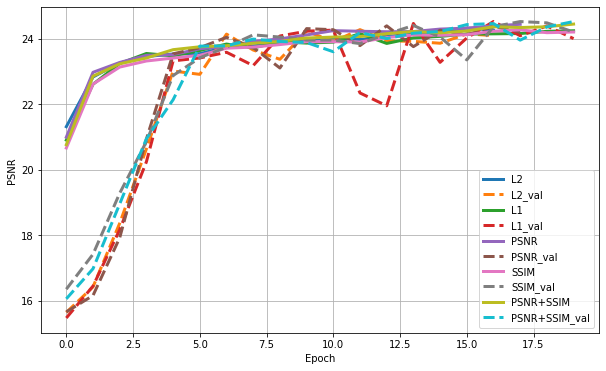

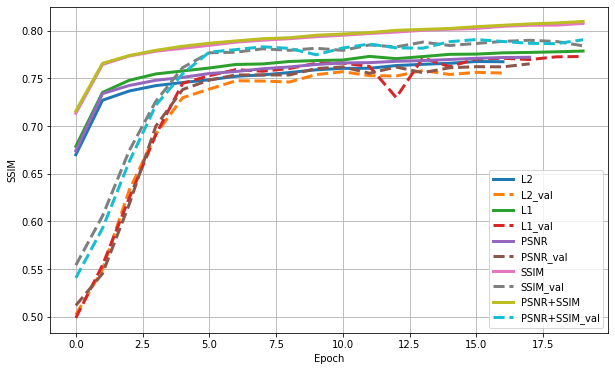

In [ ]:
plot_all_psnr(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)
plot_all_ssim(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)

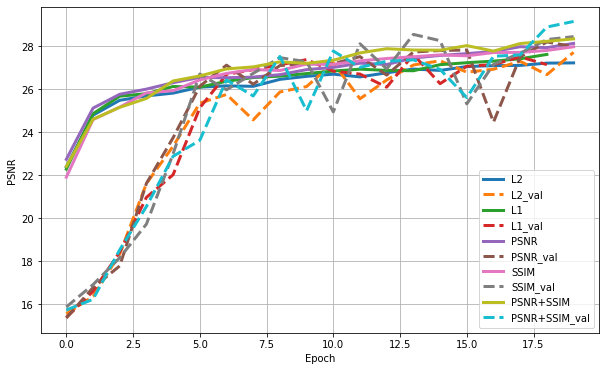

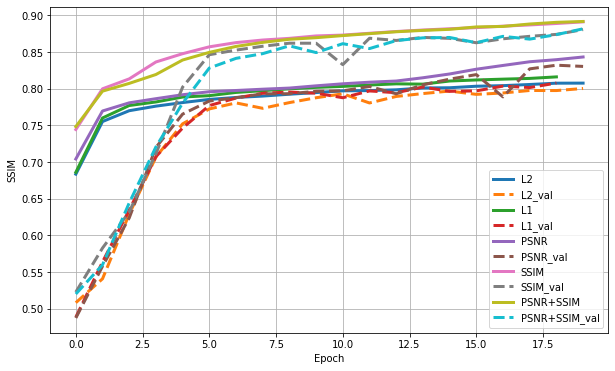

In [ ]:
plot_all_psnr(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)
plot_all_ssim(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)

# Residual Autoencoder

## MSE Loss (L2)

In [ ]:
model_pixelated = build_model3()
model_pixelated.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
# Train the model
history_pixelated1 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated1 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated1 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 24s 103ms/step - loss: 1014.2550 - psnr: 19.2864 - ssim: 0.4638 - val_loss: 2440.6184 - val_psnr: 14.5195 - val_ssim: 0.4240
Epoch 2/20
125/125 [==============================] - 12s 93ms/step - loss: 427.0838 - psnr: 22.0508 - ssim: 0.6205 - val_loss: 1811.4620 - val_psnr: 15.8031 - val_ssim: 0.4915
Epoch 3/20
125/125 [==============================] - 12s 95ms/step - loss: 367.7017 - psnr: 22.6985 - ssim: 0.6617 - val_loss: 1011.3832 - val_psnr: 18.3154 - val_ssim: 0.5911
Epoch 4/20
125/125 [==============================] - 12s 95ms/step - loss: 344.6742 - psnr: 23.0118 - ssim: 0.6807 - val_loss: 444.0725 - val_psnr: 21.8369 - val_ssim: 0.6701
Epoch 5/20
125/125 [==============================] - 12s 96ms/step - loss: 317.0761 - psnr: 23.3746 - ssim: 0.6977 - val_loss: 334.2995 - val_psnr: 23.1311 - val_ssim: 0.6937
Epoch 6/20
125/125 [==============================] - 12s 96ms/step - loss: 315.7628 - psnr: 23.3944 - ssim: 0.7087

In [ ]:
model_blurred = build_model3()
model_blurred.compile(optimizer=optimizer, loss=pixel_loss,  metrics=[psnr, ssim])
history_blurred1 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred1 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred1 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 15s 103ms/step - loss: 650.5005 - psnr: 20.9424 - ssim: 0.5707 - val_loss: 1999.3369 - val_psnr: 15.3899 - val_ssim: 0.4801
Epoch 2/20
125/125 [==============================] - 12s 98ms/step - loss: 286.7707 - psnr: 23.7882 - ssim: 0.7014 - val_loss: 1412.7345 - val_psnr: 16.8653 - val_ssim: 0.5458
Epoch 3/20
125/125 [==============================] - 12s 97ms/step - loss: 252.9633 - psnr: 24.3707 - ssim: 0.7378 - val_loss: 843.9621 - val_psnr: 19.0864 - val_ssim: 0.6285
Epoch 4/20
125/125 [==============================] - 12s 97ms/step - loss: 214.1428 - psnr: 25.1060 - ssim: 0.7561 - val_loss: 347.9372 - val_psnr: 22.8943 - val_ssim: 0.7212
Epoch 5/20
125/125 [==============================] - 12s 97ms/step - loss: 176.4192 - psnr: 25.9015 - ssim: 0.7696 - val_loss: 210.0605 - val_psnr: 25.0557 - val_ssim: 0.7640
Epoch 6/20
125/125 [==============================] - 12s 97ms/step - loss: 178.7158 - psnr: 25.9482 - ssim: 0.7778 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 4s - loss: 119.6597 - psnr: 27.5846 - ssim: 0.8301 - 4s/epoch - 70ms/step
16/16 - 2s - loss: 126.9271 - psnr: 27.3430 - ssim: 0.8224 - 2s/epoch - 100ms/step
63/63 - 4s - loss: 165.0306 - psnr: 26.1573 - ssim: 0.7866 - 4s/epoch - 59ms/step
16/16 - 1s - loss: 254.1660 - psnr: 24.3998 - ssim: 0.7492 - 982ms/epoch - 61ms/step


## MAE Loss (L1)

In [ ]:
model_pixelated = build_model3()
model_pixelated.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_pixelated2 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated2 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated2 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 15s 105ms/step - loss: 18.8729 - psnr: 20.3466 - ssim: 0.5711 - val_loss: 30.6641 - val_psnr: 16.5265 - val_ssim: 0.5272
Epoch 2/20
125/125 [==============================] - 12s 97ms/step - loss: 14.4066 - psnr: 22.1945 - ssim: 0.6867 - val_loss: 23.5728 - val_psnr: 18.7134 - val_ssim: 0.6105
Epoch 3/20
125/125 [==============================] - 12s 100ms/step - loss: 13.2947 - psnr: 22.7467 - ssim: 0.7094 - val_loss: 16.2008 - val_psnr: 21.4906 - val_ssim: 0.6776
Epoch 4/20
125/125 [==============================] - 12s 97ms/step - loss: 12.7448 - psnr: 23.0406 - ssim: 0.7225 - val_loss: 14.8485 - val_psnr: 22.2810 - val_ssim: 0.7093
Epoch 5/20
125/125 [==============================] - 12s 97ms/step - loss: 12.7649 - psnr: 23.0659 - ssim: 0.7294 - val_loss: 11.9194 - val_psnr: 23.4994 - val_ssim: 0.7283
Epoch 6/20
125/125 [==============================] - 12s 97ms/step - loss: 12.6293 - psnr: 23.1707 - ssim: 0.7357 - val_loss: 1

In [ ]:
model_blurred = build_model3()
model_blurred.compile(optimizer=optimizer, loss=L1_loss,  metrics=[psnr, ssim])
history_blurred2 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred2 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred2 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 16s 106ms/step - loss: 19.4750 - psnr: 20.3691 - ssim: 0.5802 - val_loss: 34.1476 - val_psnr: 15.7185 - val_ssim: 0.5071
Epoch 2/20
125/125 [==============================] - 12s 99ms/step - loss: 13.3292 - psnr: 23.2483 - ssim: 0.6999 - val_loss: 25.7015 - val_psnr: 18.2270 - val_ssim: 0.5973
Epoch 3/20
125/125 [==============================] - 12s 100ms/step - loss: 11.5709 - psnr: 24.4644 - ssim: 0.7440 - val_loss: 18.6810 - val_psnr: 20.8669 - val_ssim: 0.6854
Epoch 4/20
125/125 [==============================] - 12s 99ms/step - loss: 11.1704 - psnr: 24.8431 - ssim: 0.7626 - val_loss: 10.6977 - val_psnr: 24.9674 - val_ssim: 0.7496
Epoch 5/20
125/125 [==============================] - 12s 97ms/step - loss: 10.7294 - psnr: 25.2113 - ssim: 0.7747 - val_loss: 9.8276 - val_psnr: 25.7816 - val_ssim: 0.7754
Epoch 6/20
125/125 [==============================] - 12s 97ms/step - loss: 10.2796 - psnr: 25.5783 - ssim: 0.7843 - val_loss: 9.

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 4s - loss: 7.5180 - psnr: 28.0884 - ssim: 0.8368 - 4s/epoch - 58ms/step
16/16 - 1s - loss: 7.6508 - psnr: 27.9211 - ssim: 0.8301 - 934ms/epoch - 58ms/step
63/63 - 4s - loss: 11.1826 - psnr: 24.2364 - ssim: 0.7689 - 4s/epoch - 58ms/step
16/16 - 1s - loss: 11.5236 - psnr: 23.9235 - ssim: 0.7541 - 927ms/epoch - 58ms/step


## PSNR Loss

In [ ]:
model_pixelated = build_model3()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_pixelated3 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated3 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated3 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 15s 105ms/step - loss: 0.0498 - psnr: 20.3008 - ssim: 0.5918 - val_loss: 0.0603 - val_psnr: 16.5992 - val_ssim: 0.5430
Epoch 2/20
125/125 [==============================] - 12s 97ms/step - loss: 0.0446 - psnr: 22.4172 - ssim: 0.6943 - val_loss: 0.0546 - val_psnr: 18.3371 - val_ssim: 0.6039
Epoch 3/20
125/125 [==============================] - 12s 100ms/step - loss: 0.0439 - psnr: 22.8019 - ssim: 0.7152 - val_loss: 0.0470 - val_psnr: 21.2642 - val_ssim: 0.6784
Epoch 4/20
125/125 [==============================] - 12s 99ms/step - loss: 0.0433 - psnr: 23.1395 - ssim: 0.7273 - val_loss: 0.0431 - val_psnr: 23.2319 - val_ssim: 0.7226
Epoch 5/20
125/125 [==============================] - 12s 98ms/step - loss: 0.0430 - psnr: 23.2885 - ssim: 0.7355 - val_loss: 0.0426 - val_psnr: 23.4705 - val_ssim: 0.7355
Epoch 6/20
125/125 [==============================] - 12s 96ms/step - loss: 0.0424 - psnr: 23.5898 - ssim: 0.7408 - val_loss: 0.0419 - val

1/1 [==============================] - 0s 25ms/step


In [ ]:
model_blurred = build_model3()
model_blurred.compile(optimizer=optimizer, loss=PSNR_loss,  metrics=[psnr, ssim])
history_blurred3 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred3 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred3 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 15s 103ms/step - loss: 0.0492 - psnr: 20.6620 - ssim: 0.5914 - val_loss: 0.0628 - val_psnr: 15.9414 - val_ssim: 0.5165
Epoch 2/20
125/125 [==============================] - 12s 96ms/step - loss: 0.0423 - psnr: 23.6828 - ssim: 0.7196 - val_loss: 0.0573 - val_psnr: 17.4499 - val_ssim: 0.5837
Epoch 3/20
125/125 [==============================] - 12s 98ms/step - loss: 0.0402 - psnr: 24.8795 - ssim: 0.7585 - val_loss: 0.0502 - val_psnr: 19.9151 - val_ssim: 0.6794
Epoch 4/20
125/125 [==============================] - 12s 99ms/step - loss: 0.0392 - psnr: 25.5211 - ssim: 0.7766 - val_loss: 0.0417 - val_psnr: 24.0087 - val_ssim: 0.7606
Epoch 5/20
125/125 [==============================] - 12s 100ms/step - loss: 0.0389 - psnr: 25.7283 - ssim: 0.7886 - val_loss: 0.0400 - val_psnr: 24.9782 - val_ssim: 0.7757
Epoch 6/20
125/125 [==============================] - 12s 99ms/step - loss: 0.0386 - psnr: 25.9550 - ssim: 0.7929 - val_loss: 0.0385 - val

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 4s - loss: 0.0341 - psnr: 29.3583 - ssim: 0.8544 - 4s/epoch - 58ms/step
16/16 - 1s - loss: 0.0344 - psnr: 29.0591 - ssim: 0.8459 - 966ms/epoch - 60ms/step
63/63 - 4s - loss: 0.0391 - psnr: 25.5830 - ssim: 0.7902 - 4s/epoch - 57ms/step
16/16 - 1s - loss: 0.0407 - psnr: 24.5705 - ssim: 0.7664 - 1s/epoch - 64ms/step


## SSIM Loss

In [ ]:
model_pixelated = build_model3()
model_pixelated.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_pixelated4 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated4 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated4 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 16s 108ms/step - loss: 0.3470 - psnr: 19.3270 - ssim: 0.6530 - val_loss: 0.4820 - val_psnr: 15.8787 - val_ssim: 0.5180
Epoch 2/20
125/125 [==============================] - 12s 100ms/step - loss: 0.2585 - psnr: 21.3961 - ssim: 0.7415 - val_loss: 0.4064 - val_psnr: 17.3030 - val_ssim: 0.5936
Epoch 3/20
125/125 [==============================] - 13s 102ms/step - loss: 0.2429 - psnr: 21.8109 - ssim: 0.7571 - val_loss: 0.3350 - val_psnr: 18.7258 - val_ssim: 0.6650
Epoch 4/20
125/125 [==============================] - 13s 103ms/step - loss: 0.2315 - psnr: 22.3065 - ssim: 0.7685 - val_loss: 0.2725 - val_psnr: 20.3525 - val_ssim: 0.7275
Epoch 5/20
125/125 [==============================] - 13s 102ms/step - loss: 0.2212 - psnr: 22.7388 - ssim: 0.7788 - val_loss: 0.2428 - val_psnr: 21.6636 - val_ssim: 0.7572
Epoch 6/20
125/125 [==============================] - 13s 100ms/step - loss: 0.2132 - psnr: 23.0175 - ssim: 0.7868 - val_loss: 0.2262 -

In [ ]:
model_blurred = build_model3()
model_blurred.compile(optimizer=optimizer, loss=SSIM_loss,  metrics=[psnr, ssim])
history_blurred4 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred4 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred4 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 17s 115ms/step - loss: 0.4371 - psnr: 17.2822 - ssim: 0.5629 - val_loss: 0.5347 - val_psnr: 14.7558 - val_ssim: 0.4653
Epoch 2/20
125/125 [==============================] - 12s 100ms/step - loss: 0.2264 - psnr: 22.2649 - ssim: 0.7736 - val_loss: 0.4777 - val_psnr: 16.0986 - val_ssim: 0.5223
Epoch 3/20
125/125 [==============================] - 13s 100ms/step - loss: 0.1977 - psnr: 22.9229 - ssim: 0.8023 - val_loss: 0.3791 - val_psnr: 17.9662 - val_ssim: 0.6209
Epoch 4/20
125/125 [==============================] - 13s 102ms/step - loss: 0.1776 - psnr: 23.7526 - ssim: 0.8224 - val_loss: 0.2666 - val_psnr: 21.5375 - val_ssim: 0.7334
Epoch 5/20
125/125 [==============================] - 13s 101ms/step - loss: 0.1627 - psnr: 24.6985 - ssim: 0.8373 - val_loss: 0.1889 - val_psnr: 23.3341 - val_ssim: 0.8111
Epoch 6/20
125/125 [==============================] - 13s 102ms/step - loss: 0.1531 - psnr: 25.0589 - ssim: 0.8469 - val_loss: 0.1773 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 4s - loss: 0.0873 - psnr: 28.3404 - ssim: 0.9127 - 4s/epoch - 62ms/step
16/16 - 1s - loss: 0.1033 - psnr: 28.0636 - ssim: 0.8967 - 979ms/epoch - 61ms/step
63/63 - 4s - loss: 0.1388 - psnr: 25.3908 - ssim: 0.8612 - 4s/epoch - 61ms/step
16/16 - 1s - loss: 0.2124 - psnr: 23.9914 - ssim: 0.7876 - 1s/epoch - 63ms/step


## PSNR + SSIM Loss

In [ ]:
model_pixelated = build_model3()
model_pixelated.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_pixelated5 = model_pixelated.fit(X_train_pixelated, y_train, epochs=20, batch_size=16, validation_data=(X_test_pixelated, y_test), callbacks=callbacks)
# Predict using the model
train_pred_pixelated5 = model_pixelated.predict(X_train_pixelated[:10])
test_pred_pixelated5 = model_pixelated.predict(X_test_pixelated[:10])

Epoch 1/20
125/125 [==============================] - 16s 109ms/step - loss: 0.4875 - psnr: 16.4212 - ssim: 0.5283 - val_loss: 0.5723 - val_psnr: 12.6270 - val_ssim: 0.4476
Epoch 2/20
125/125 [==============================] - 13s 100ms/step - loss: 0.2841 - psnr: 20.8642 - ssim: 0.7279 - val_loss: 0.4573 - val_psnr: 15.9637 - val_ssim: 0.5584
Epoch 3/20
125/125 [==============================] - 13s 102ms/step - loss: 0.2663 - psnr: 21.3456 - ssim: 0.7454 - val_loss: 0.3827 - val_psnr: 18.4117 - val_ssim: 0.6309
Epoch 4/20
125/125 [==============================] - 13s 103ms/step - loss: 0.2572 - psnr: 21.5486 - ssim: 0.7544 - val_loss: 0.2889 - val_psnr: 20.5899 - val_ssim: 0.7233
Epoch 5/20
125/125 [==============================] - 13s 102ms/step - loss: 0.2492 - psnr: 21.8226 - ssim: 0.7623 - val_loss: 0.2681 - val_psnr: 21.1176 - val_ssim: 0.7438
Epoch 6/20
125/125 [==============================] - 13s 102ms/step - loss: 0.2402 - psnr: 22.3489 - ssim: 0.7710 - val_loss: 0.2505 -

In [ ]:
model_blurred = build_model3()
model_blurred.compile(optimizer=optimizer, loss=PSNR_SSIM_loss,  metrics=[psnr, ssim])
history_blurred5 = model_blurred.fit(X_train_blurred, y_train, epochs=20, batch_size=16, validation_data=(X_test_blurred, y_test), callbacks=callbacks)
# Predict using the model
train_pred_blurred5 = model_blurred.predict(X_train_blurred[:10])
test_pred_blurred5 = model_blurred.predict(X_test_blurred[:10])

Epoch 1/20
125/125 [==============================] - 16s 109ms/step - loss: 0.3594 - psnr: 19.9345 - ssim: 0.6534 - val_loss: 0.5233 - val_psnr: 15.4750 - val_ssim: 0.4929
Epoch 2/20
125/125 [==============================] - 13s 101ms/step - loss: 0.2211 - psnr: 22.8106 - ssim: 0.7898 - val_loss: 0.4631 - val_psnr: 16.6792 - val_ssim: 0.5519
Epoch 3/20
125/125 [==============================] - 13s 101ms/step - loss: 0.1932 - psnr: 23.5012 - ssim: 0.8174 - val_loss: 0.3482 - val_psnr: 19.7045 - val_ssim: 0.6645
Epoch 4/20
125/125 [==============================] - 13s 102ms/step - loss: 0.1760 - psnr: 24.3514 - ssim: 0.8343 - val_loss: 0.2638 - val_psnr: 21.5689 - val_ssim: 0.7478
Epoch 5/20
125/125 [==============================] - 13s 101ms/step - loss: 0.1620 - psnr: 25.1185 - ssim: 0.8480 - val_loss: 0.1921 - val_psnr: 25.1526 - val_ssim: 0.8179
Epoch 6/20
125/125 [==============================] - 13s 100ms/step - loss: 0.1497 - psnr: 25.7074 - ssim: 0.8600 - val_loss: 0.1667 -

In [ ]:
train_scores_blurred = model_blurred.evaluate(X_train_blurred, y_train, verbose=2)
test_scores_blurred = model_blurred.evaluate(X_test_blurred, y_test, verbose=2)

train_scores_pixelated = model_pixelated.evaluate(X_train_pixelated, y_train, verbose=2)
test_scores_pixelated = model_pixelated.evaluate(X_test_pixelated, y_test, verbose=2)

63/63 - 4s - loss: 0.0932 - psnr: 28.6523 - ssim: 0.9155 - 4s/epoch - 62ms/step
16/16 - 1s - loss: 0.1098 - psnr: 28.3727 - ssim: 0.8990 - 995ms/epoch - 62ms/step
63/63 - 4s - loss: 0.1635 - psnr: 25.2175 - ssim: 0.8464 - 4s/epoch - 61ms/step
16/16 - 1s - loss: 0.2247 - psnr: 24.0194 - ssim: 0.7857 - 972ms/epoch - 61ms/step


## Plots

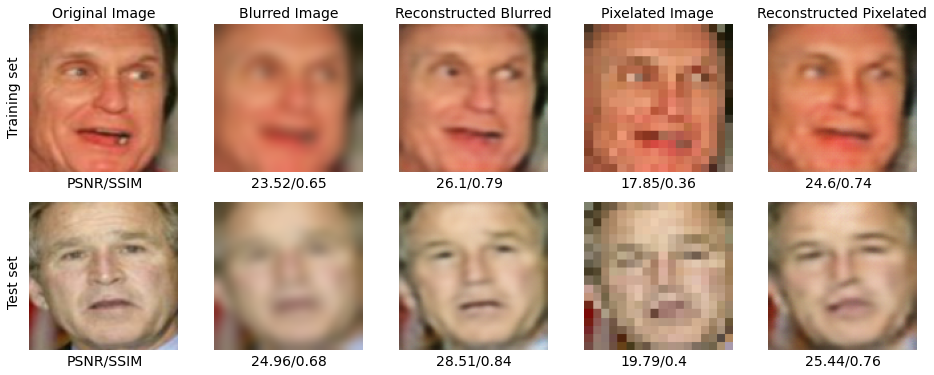

In [ ]:
# Pixel Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred1, test_pred_blurred1, train_pred_pixelated1, test_pred_pixelated1)

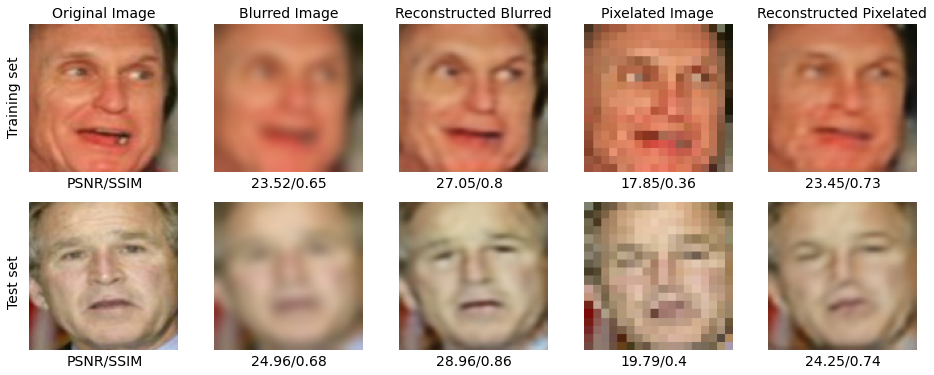

In [ ]:
# L1 Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred2, test_pred_blurred2, train_pred_pixelated2, test_pred_pixelated2)

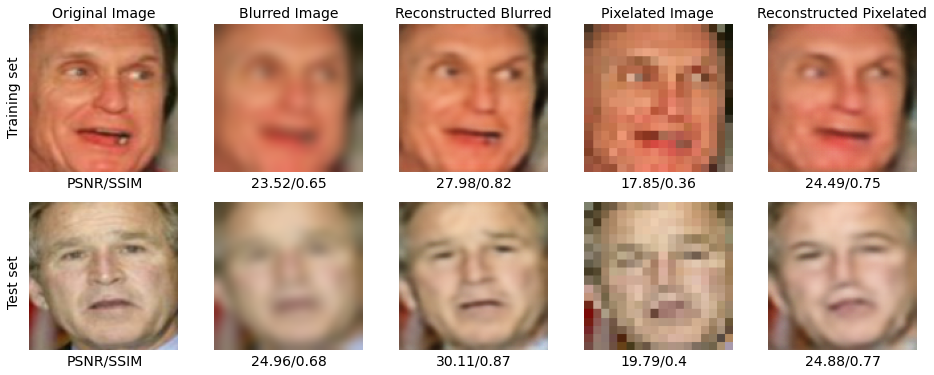

In [ ]:
# PSNR Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred3, test_pred_blurred3, train_pred_pixelated3, test_pred_pixelated3)

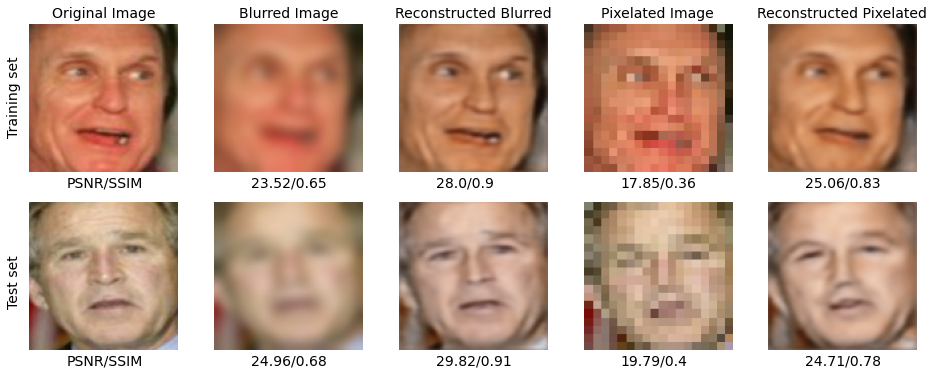

In [ ]:
# SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred4, test_pred_blurred4, train_pred_pixelated4, test_pred_pixelated4)

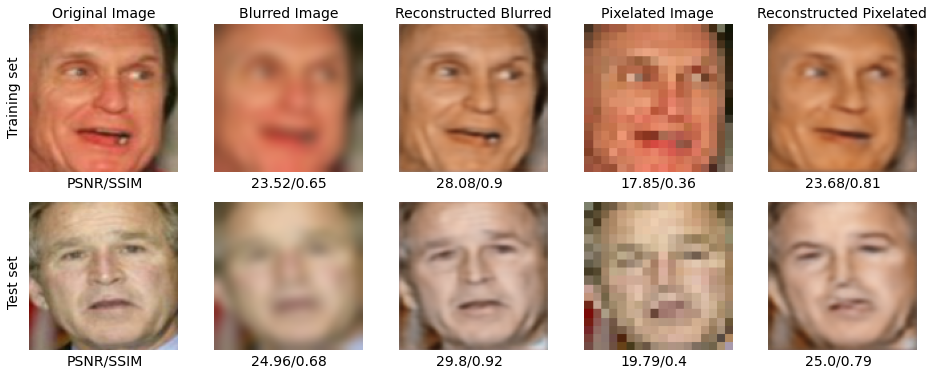

In [ ]:
# PSNR + SSIM Loss
plot_images(y_train, y_test, X_train_blurred, X_test_blurred, X_train_pixelated, X_test_pixelated, train_pred_blurred5, test_pred_blurred5, train_pred_pixelated5, test_pred_pixelated5)

## Losses Plots

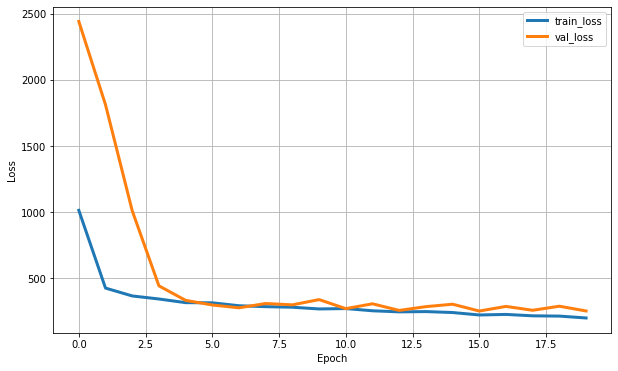

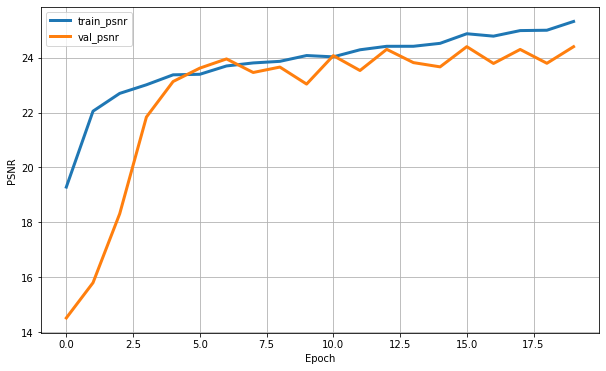

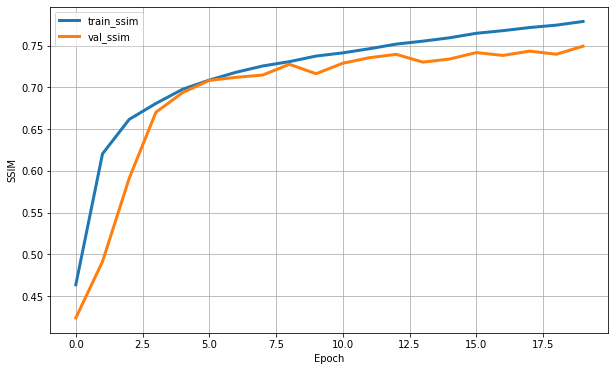

In [ ]:
plot_loss(history_pixelated1)
plot_psnr(history_pixelated1)
plot_ssim(history_pixelated1)

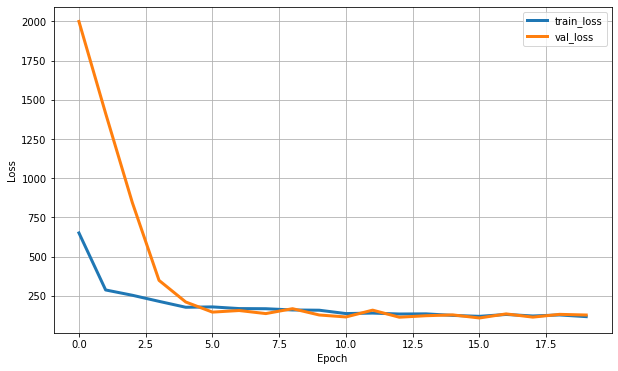

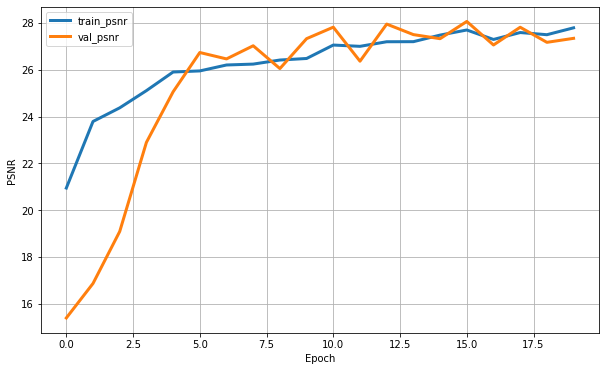

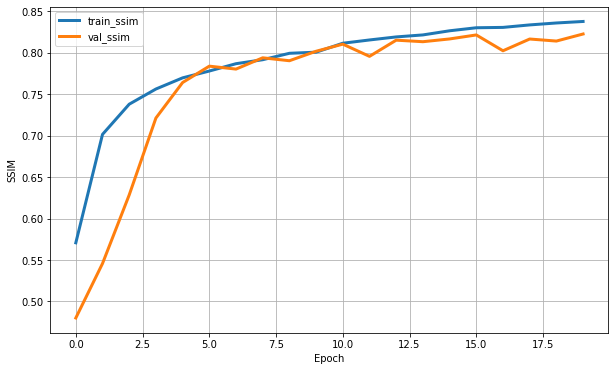

In [ ]:
plot_loss(history_blurred1)
plot_psnr(history_blurred1)
plot_ssim(history_blurred1)

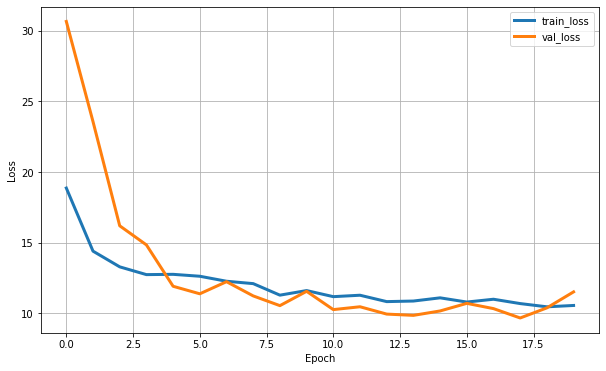

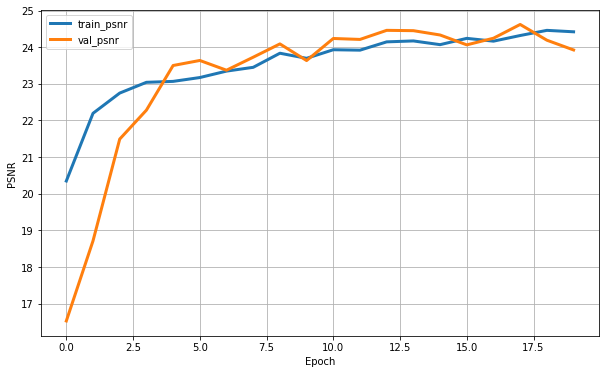

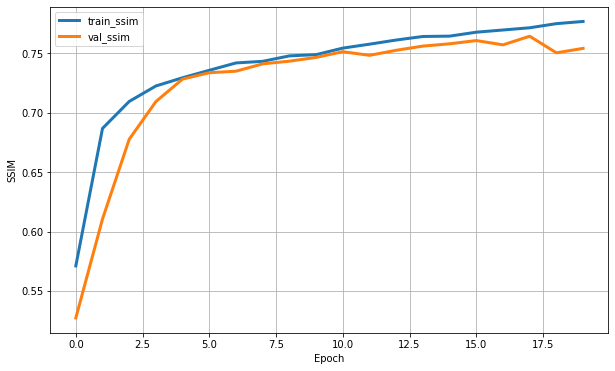

In [ ]:
plot_loss(history_pixelated2)
plot_psnr(history_pixelated2)
plot_ssim(history_pixelated2)

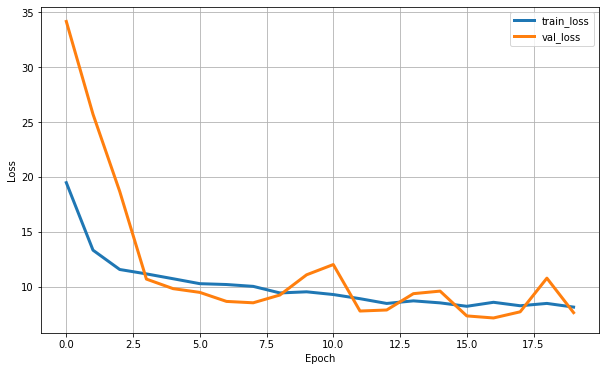

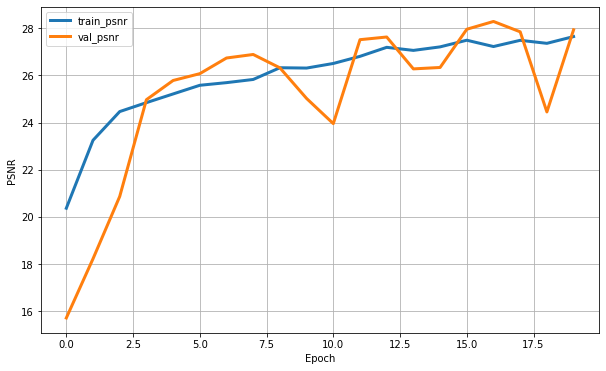

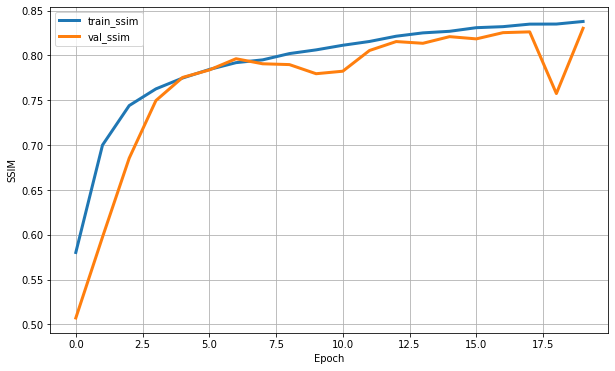

In [ ]:
plot_loss(history_blurred2)
plot_psnr(history_blurred2)
plot_ssim(history_blurred2)

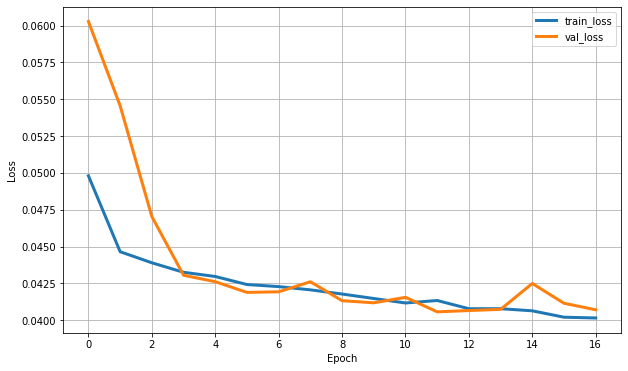

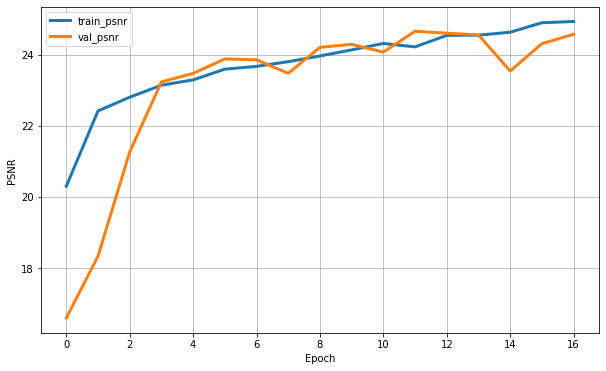

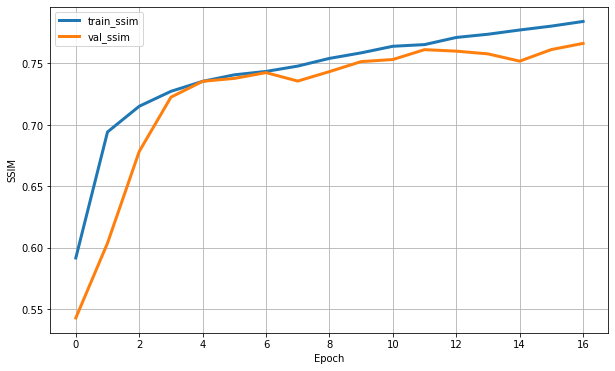

In [ ]:
plot_loss(history_pixelated3)
plot_psnr(history_pixelated3)
plot_ssim(history_pixelated3)

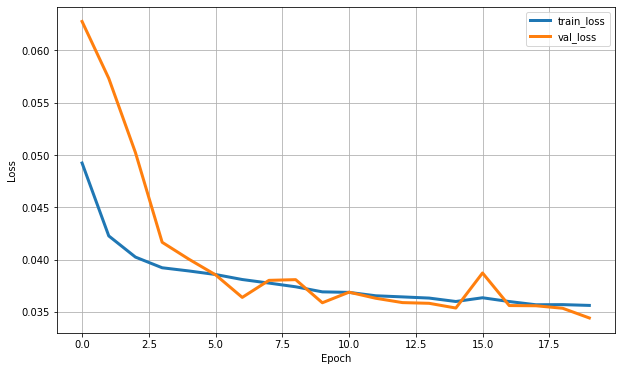

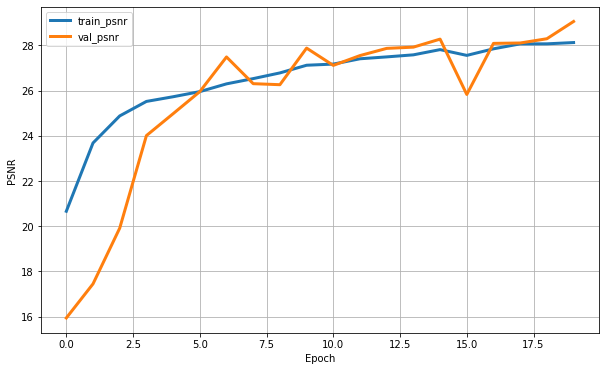

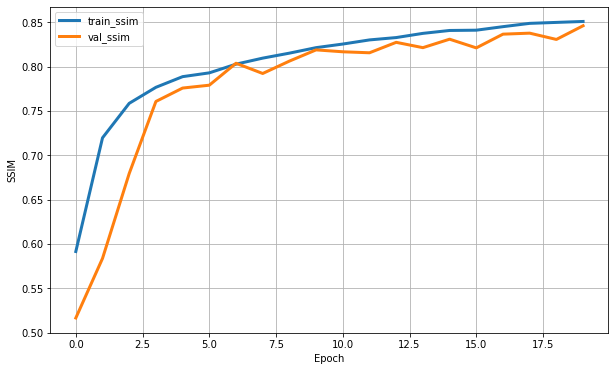

In [ ]:
plot_loss(history_blurred3)
plot_psnr(history_blurred3)
plot_ssim(history_blurred3)

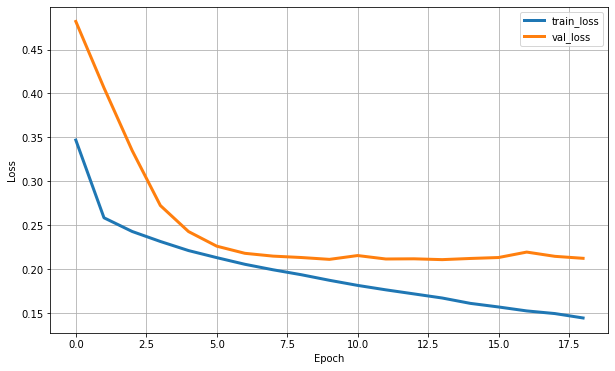

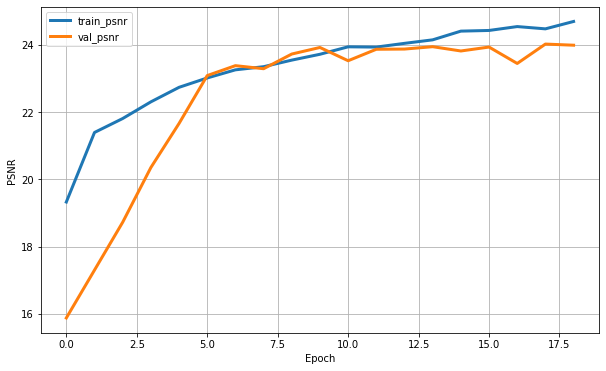

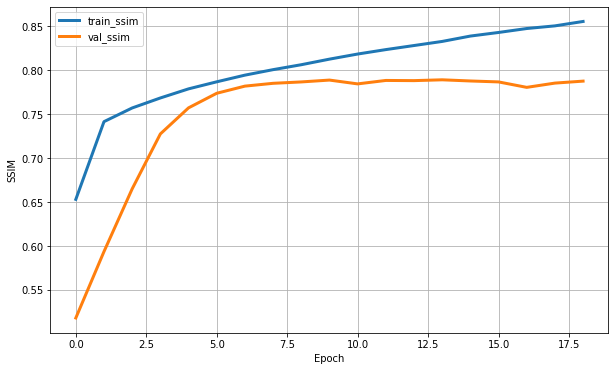

In [ ]:
plot_loss(history_pixelated4)
plot_psnr(history_pixelated4)
plot_ssim(history_pixelated4)

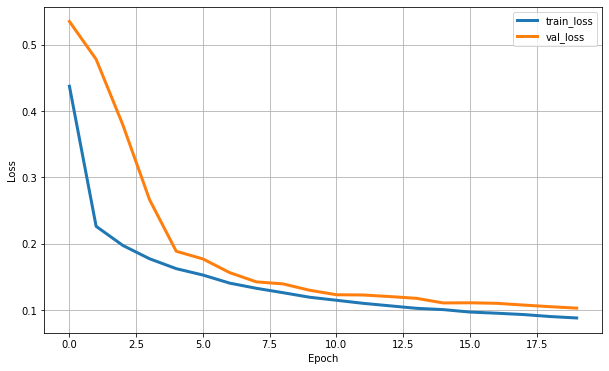

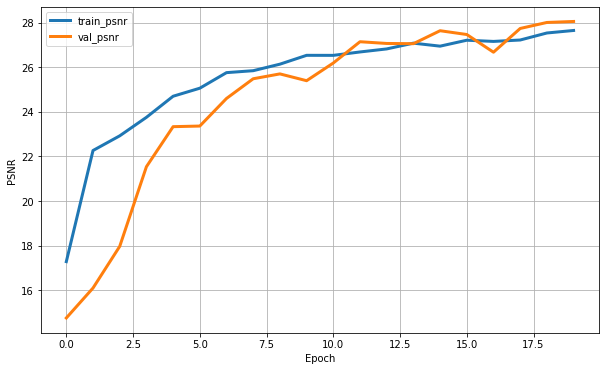

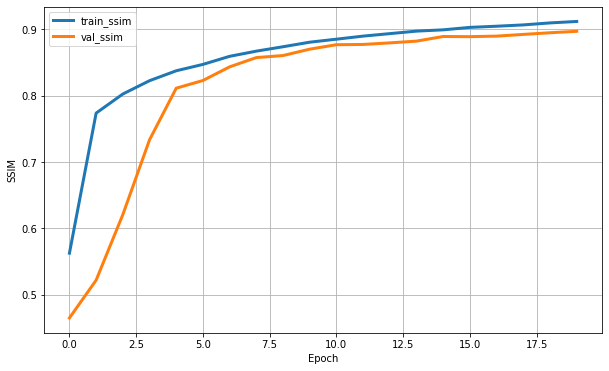

In [ ]:
plot_loss(history_blurred4)
plot_psnr(history_blurred4)
plot_ssim(history_blurred4)

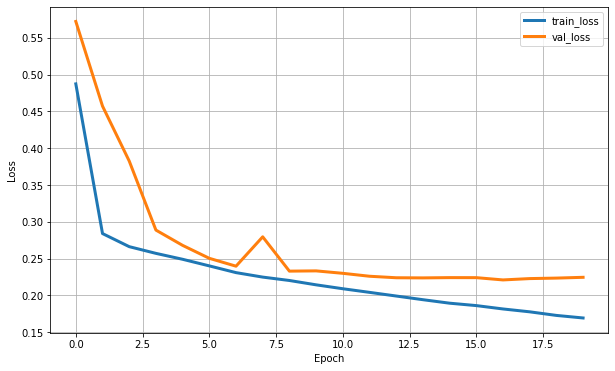

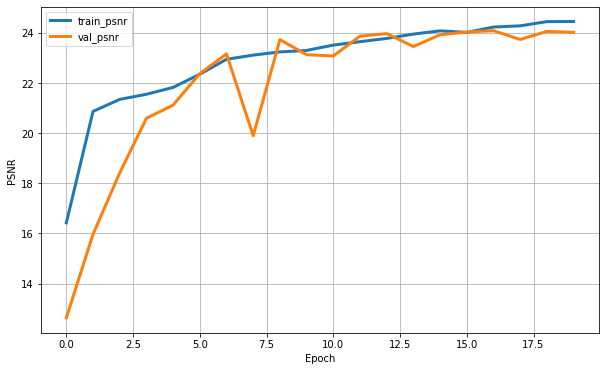

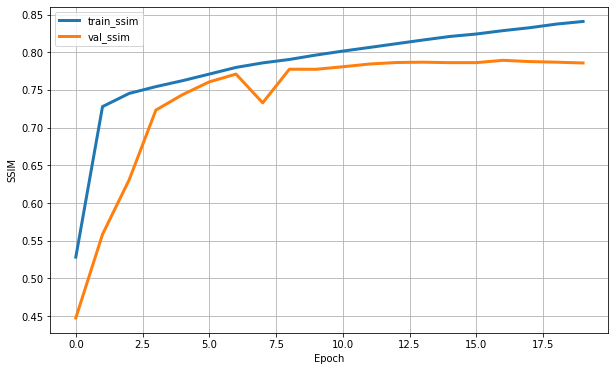

In [ ]:
plot_loss(history_pixelated5)
plot_psnr(history_pixelated5)
plot_ssim(history_pixelated5)

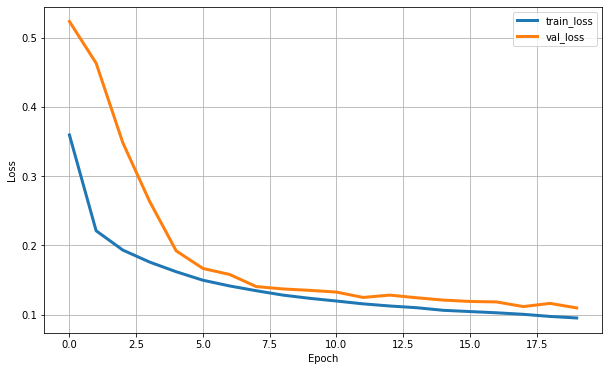

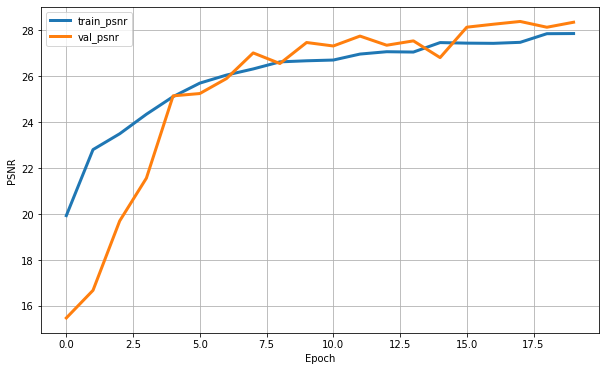

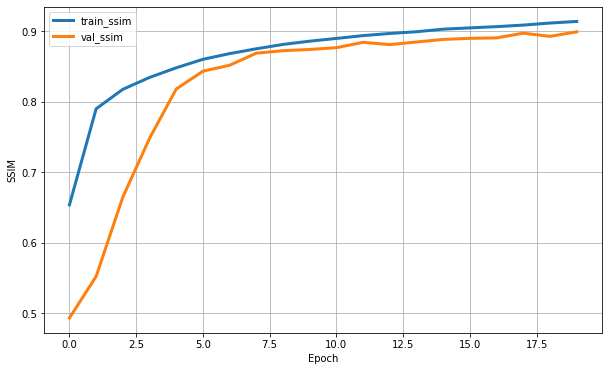

In [ ]:
plot_loss(history_blurred5)
plot_psnr(history_blurred5)
plot_ssim(history_blurred5)

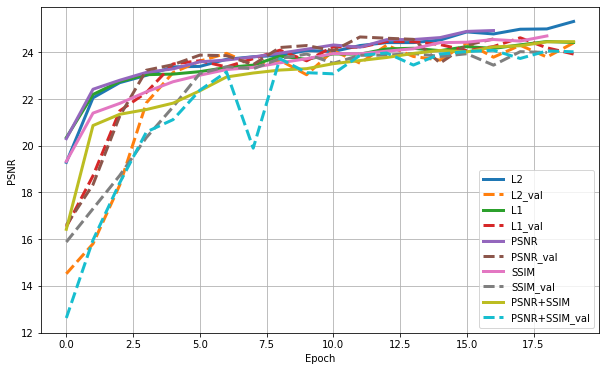

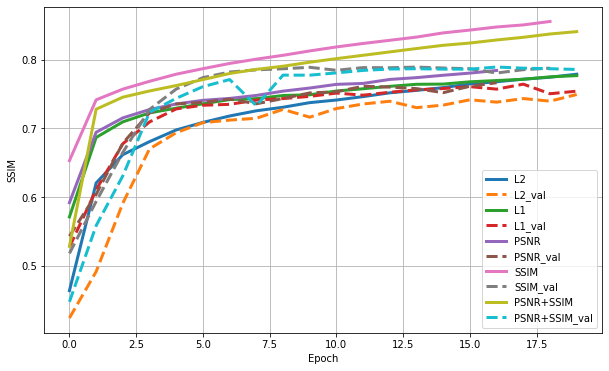

In [ ]:
plot_all_psnr(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)
plot_all_ssim(history_pixelated1,history_pixelated2,history_pixelated3,history_pixelated4,history_pixelated5)

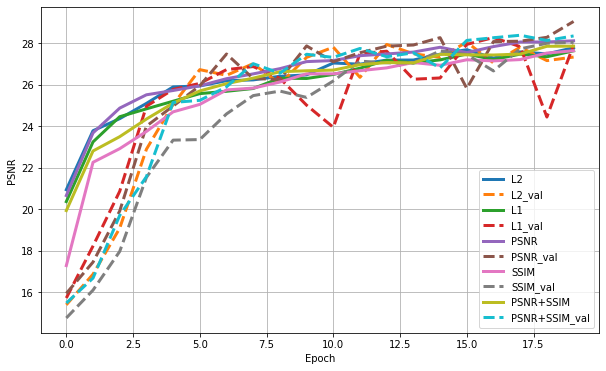

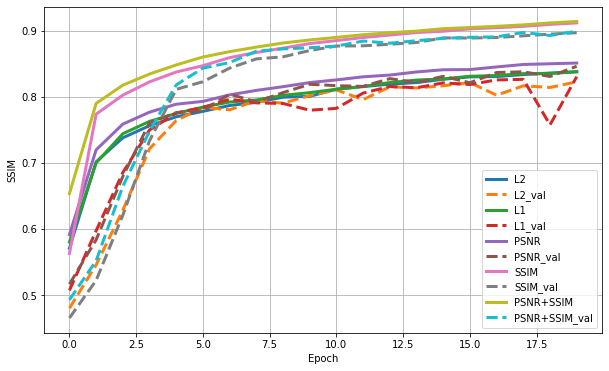

In [ ]:
plot_all_psnr(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)
plot_all_ssim(history_blurred1,history_blurred2,history_blurred3,history_blurred4,history_blurred5)